# Importing Modules

In [1]:
import os
# Importing Modulesimport os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import sys

# This allows us to import the nucml utilities
sys.path.append("..")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
import nucml.exfor.data_utilities as exfor_utils
import nucml.endf.data_utilities as endf_utils
import nucml.plot.plotting_utilities as plot_utils
import nucml.datasets as nuc_data
import nucml.ace.data_utilities as ace_utils
import nucml.model.model_building_nn as model_tools
importlib.reload(model_tools)
importlib.reload(exfor_utils)
importlib.reload(endf_utils)
importlib.reload(plot_utils)
importlib.reload(nuc_data)
importlib.reload(ace_utils)
print("Finish importing scripts.")

Finish importing scripts.


In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [5]:
%tensorboard --logdir testing_logs_2 --port=6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 40920.

# Setting Up ML Management Tools

# Loading EXFOR data (Energy in eV and Data in b)

In [8]:
df, x_train, x_test, y_train, y_test, to_scale, scaler = nuc_data.load_exfor(log=True, basic=0, num=True, low_en=True)

C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\EXFOR_neutrons\EXFOR_neutrons_MF3_AME_no_NaNRaw.csv
Reading data into dataframe...
 MODE: neutrons
 LOW ENERGY: True
 LOG: True
 BASIC: 0
Data read into dataframe with shape:  (4184245, 10)
Dropping unnecessary features and one-hot encoding categorical columns...
Splitting dataset into training and testing...
Normalizing dataset...
Finished. Resulting dataset has shape  (4184245, 49) 
Training and Testing dataset shapes are (3765820, 48) and (418425, 48) respesctively.


# Sampling Chlorine (n,p) and U-233(n,f) Data for Visualization

The model will be trained in the entire data therefore getting the total MSE. As an example, we will see the model predictions for both the mentioned reactions. 

In [6]:
kwargs = {"nat_iso": "I", "one_hot": True, "scale": True, "scaler": scaler, "to_scale": to_scale}

chlorine_35_np = exfor_utils.load_exfor_samples(df, 17, 35, "MT_103", **kwargs)
uranium_235_nt = exfor_utils.load_exfor_samples(df, 92, 235, "MT_1", **kwargs)
uranium_233_nf = exfor_utils.load_exfor_samples(df, 92, 233, "MT_18", **kwargs)
uranium_233_nt = exfor_utils.load_exfor_samples(df, 92, 233, "MT_1", one_hot=True)

Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 59)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (40108, 59)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 59)
Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (33384, 59)


In [7]:
kwargs = {"nat_iso": "I", "one_hot": True, "scale": True, "scaler": scaler, "to_scale": to_scale}
uranium = exfor_utils.load_exfor_element(df, 92, **kwargs)

Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (468123, 59)


# Newly Measured Chlorine (n,p) Unseen Data 

These data points are not in the current EXFOR data package and will be used to test the new modeling capabilities.

In [8]:
new_cl_data_kwargs = {"Z":17, "A":35, "MT":"MT_103", "log":True, "scale":False, "scaler":scaler, "to_scale":to_scale}
new_cl_data = exfor_utils.load_exfor_newdata("../EXFOR/New_Data/Chlorine_Data/new_cl_np.csv", df, **new_cl_data_kwargs)
new_cl_data.head()

Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (215, 59)
Expanded Dataset has shape:  (12, 59)


Energy      Data  Target_Protons  Target_Neutrons  Target_Mass_Number  \
0  6.383815 -1.779892              17               18                  35   
1  6.383815 -1.707744              17               18                  35   
2  6.401401 -1.583359              17               18                  35   
3  6.401401 -1.590067              17               18                  35   
4  6.411620 -1.350665              17               18                  35   

   Target_Radius  Target_Neut_Rad_Ratio  Target_Mass_Excess  \
0       4.088833               0.195655          -29013.528   
1       4.088833               0.195655          -29013.528   
2       4.088833               0.195655          -29013.528   
3       4.088833               0.195655          -29013.528   
4       4.088833               0.195655          -29013.528   

   Target_Binding_Energy  Target_B_Decay_Energy  Target_Atomic_Mass_Micro  \
0               8520.278              -5966.243              3.496885e+07   
1               8520.278              -5966.243              3.496885e+07   
2               8520.278              -5966.243              3.496885e+07   
3               8520.278              -5966.243              3.496885e+07   
4               8520.278              -5966.243              3.496885e+07   

   Target_S(2n)  Target_S(2p)  Target_S(n)  Target_S(p)  MT_1  MT_102  MT_16  \
0      24152.83      17254.12     12644.76      6370.81     0       0      0   
1      24152.83      17254.12     12644.76      6370.81     0       0      0   
2      24152.83      17254.12     12644.76      6370.81     0       0      0   
3      24152.83      17254.12     12644.76      6370.81     0       0      0   
4      24152.83      17254.12     12644.76      6370.81     0       0      0   

   MT_17  MT_2  MT_3  MT_4  MT_101  MT_103  MT_104  MT_41  MT_9000  MT_105  \
0      0     0     0     0       0       1       0      0        0       0   
1      0     0     0     0       0       1       0      0        0       0   
2      0     0     0     0       0       1       0      0        0       0   
3      0     0     0     0       0       1       0      0        0       0   
4      0     0     0     0       0       1       0      0        0       0   

   MT_32  MT_51  MT_33  MT_107  MT_24  MT_155  MT_158  MT_159  MT_108  MT_29  \
0      0      0      0       0      0       0       0       0       0      0   
1      0      0      0       0      0       0       0       0       0      0   
2      0      0      0       0      0       0       0       0       0      0   
3      0      0      0       0      0       0       0       0       0      0   
4      0      0      0       0      0       0       0       0       0      0   

   MT_1108  MT_113  MT_106  MT_22  MT_1003  MT_9001  MT_28  MT_111  MT_203  \
0        0       0       0      0        0        0      0       0       0   
1        0       0       0      0        0        0      0       0       0   
2        0       0       0      0        0        0      0       0       0   
3        0       0       0      0        0        0      0       0       0   
4        0       0       0      0        0        0      0       0       0   

   MT_2103  MT_112  MT_37  MT_161  MT_152  MT_153  MT_18  MT_160  Frame_L  \
0        0       0      0       0       0       0      0       0        1   
1        0       0      0       0       0       0      0       0        1   
2        0       0      0       0       0       0      0       0        1   
3        0       0      0       0       0       0      0       0        1   
4        0       0      0       0       0       0      0       0        1   

   Frame_C  Target_Flag_I  Target_Flag_N  
0        0              1              0  
1        0              1              0  
2        0              1              0  
3        0              1              0  
4        0              1              0

# ENDF Evaluation Cross Section Data for Chlorine (n,p) Reaction

These data points will serve to plot the current ENDFb5 data and compare it to the newly measured points along with the predictions

In [9]:
endf_cl = nuc_data.load_endf("Cl035", "MT103", mev_to_ev=True, mb_to_b=True, log=True)
endf_u  = nuc_data.load_endf("U233", "MT018", log=True)
endf_u_nonelastic  = nuc_data.load_endf("U233", "MT003", log=True, mb_to_b=False)

C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\Cl035\endfb8.0\tables\xs\n-Cl035-MT103.endfb8.0
Convering MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (8791, 2)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT018.endfb8.0
Convering MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (15345, 2)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT003.endfb8.0
Convering MeV to eV...
Finish reading ENDF data with shape:  (33329, 2)


# Reading ACE Energies

In [10]:
ace_u = ace_utils.get_energies("92233") * 1E6
ace_cl = ace_utils.get_energies("17035") * 1E6

# Using TensorFlow

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
print(tf.__version__)

from  IPython import display
import shutil
import tempfile
import pathlib

2.1.0


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

### Setting up Output Folder for Checkpoints and Checkpoint Callback

In [54]:
histories = {}

In [55]:
# BATCH_SIZE= 500 #150
# DECAY_EPOCHS = 10
# STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE

In [46]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'), 
    tf.keras.layers.Dense(15, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(5, activation='relu'), 
    tf.keras.layers.Dense(1)])

In [47]:
histories['Tiny'] = model_tools.compile_and_fit(model, 'Tiny', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="normal")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763800/3765820 [============================>.] - ETA: 0s - loss: 0.1498 - mae: 0.2404 - mse: 0.1498
Epoch: 0, loss:0.1497,  mae:0.2403,  mse:0.1497,  val_loss:0.1266,  val_mae:0.2218,  val_mse:0.1266,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0956 - mae: 0.1828 - mse: 0.0956 - val_loss: 0.0939 - val_mae: 0.1804 - val_mse: 0.0939Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0931 - mae: 0.1791 - mse: 0.0931 - val_loss: 0.0967 - val_mae: 0.1859 - val_mse: 0.0967

In [48]:
histories['eTiny_ITD'] = model_tools.compile_and_fit(model, 'eTiny_ITD', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763800/3765820 [============================>.] - ETA: 0s - loss: 0.0937 - mae: 0.1801 - mse: 0.0937
Epoch: 0, loss:0.0937,  mae:0.1801,  mse:0.0937,  val_loss:0.0922,  val_mae:0.1782,  val_mse:0.0922,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0785 - mae: 0.1596 - mse: 0.0785 - val_loss: 0.0791 - val_mae: 0.1604 - val_mse: 0.0791Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0757 - mae: 0.1560 - mse: 0.0757 - val_loss: 0.0769 - val_mae: 0.1573 - val_mse: 0.0769

In [49]:
histories['eTiny_Plateau'] = model_tools.compile_and_fit(model, 'eTiny_Plateau', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="plateau")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765600/3765820 [============================>.] - ETA: 0s - loss: 0.0952 - mae: 0.1834 - mse: 0.0952
Epoch: 0, loss:0.0952,  mae:0.1834,  mse:0.0952,  val_loss:0.0944,  val_mae:0.1823,  val_mse:0.0944,  
3764620/3765820 [============================>.] - ETA: 0s - loss: 0.0918 - mae: 0.1777 - mse: 0.0918.
Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
3764320/3765820 [============================>.] - ETA: 0s - loss: 0.0881 - mae: 0.1732 - mse: 0.0881.
Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0861 - mae: 0.1703 - mse: 0.0861.
Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.
3762820/3765820 [============================>.] - ETA: 0s - loss: 0.0841 - mae: 0.1676 - mse: 0.0841.
Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815

3764620/3765820 [============================>.] - ETA: 0s - loss: 0.0778 - mae: 0.1591 - mse: 0.0778.
Epoch 00088: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.
3764320/3765820 [============================>.] - ETA: 0s - loss: 0.0772 - mae: 0.1581 - mse: 0.0772.
Epoch 00093: ReduceLROnPlateau reducing learning rate to 0.00013421773910522462.
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0764 - mae: 0.1570 - mse: 0.0764 - val_loss: 0.0773 - val_mae: 0.1586 - val_mse: 0.0773

In [50]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)])

histories['eMedium_ITD'] = model_tools.compile_and_fit(medium_model, 'eMedium_ITD', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765600/3765820 [============================>.] - ETA: 0s - loss: 0.1569 - mae: 0.2509 - mse: 0.1569
Epoch: 0, loss:0.1569,  mae:0.2509,  mse:0.1569,  val_loss:0.1371,  val_mae:0.2367,  val_mse:0.1371,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1062 - mae: 0.1972 - mse: 0.1062 - val_loss: 0.1058 - val_mae: 0.1970 - val_mse: 0.1058Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1037 - mae: 0.1939 - mse: 0.1037 - val_loss: 0.1037 - val_mae: 0.1937 - val_mse: 0.1037

In [51]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1)])

histories['eLarge_ITD'] = model_tools.compile_and_fit(large_model, 'eLarge_ITD', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765000/3765820 [============================>.] - ETA: 0s - loss: 0.1448 - mae: 0.2369 - mse: 0.1448
Epoch: 0, loss:0.1448,  mae:0.2369,  mse:0.1448,  val_loss:0.1312,  val_mae:0.2232,  val_mse:0.1312,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0873 - mae: 0.1714 - mse: 0.0873 - val_loss: 0.0872 - val_mae: 0.1718 - val_mse: 0.0872Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0823 - mae: 0.1647 - mse: 0.0823 - val_loss: 0.0829 - val_mae: 0.1661 - val_mse: 0.0829

In [52]:
large_model_exp = tf.keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1)])

histories['eLarge_ITD_Exp'] = model_tools.compile_and_fit(large_model_exp, 'eLarge_ITD_Exp', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763500/3765820 [============================>.] - ETA: 0s - loss: 0.1477 - mae: 0.2392 - mse: 0.1477
Epoch: 0, loss:0.1477,  mae:0.2392,  mse:0.1477,  val_loss:0.1320,  val_mae:0.2285,  val_mse:0.1320,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0851 - mae: 0.1678 - mse: 0.0851 - val_loss: 0.0860 - val_mae: 0.1699 - val_mse: 0.0860Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0769 - mae: 0.1570 - mse: 0.0769 - val_loss: 0.0786 - val_mae: 0.1587 - val_mse: 0.0786

In [53]:
large_model_exp_2 = tf.keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1)])

histories['eLarge_ITD_Exp_2'] = model_tools.compile_and_fit(large_model_exp_2, 'eLarge_ITD_Exp_2', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765300/3765820 [============================>.] - ETA: 0s - loss: 0.1524 - mae: 0.2433 - mse: 0.1524
Epoch: 0, loss:0.1524,  mae:0.2433,  mse:0.1524,  val_loss:0.1290,  val_mae:0.2256,  val_mse:0.1290,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0848 - mae: 0.1676 - mse: 0.0848 - val_loss: 0.0839 - val_mae: 0.1663 - val_mse: 0.0839Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0772 - mae: 0.1572 - mse: 0.0772 - val_loss: 0.0771 - val_mae: 0.1569 - val_mse: 0.0771

In [54]:
large_model_elu = tf.keras.Sequential([
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)])

histories['eLarge_ITD_elu'] = model_tools.compile_and_fit(large_model_elu, 'eLarge_ITD_elu', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764700/3765820 [============================>.] - ETA: 0s - loss: 0.1837 - mae: 0.2760 - mse: 0.1837
Epoch: 0, loss:0.1837,  mae:0.2760,  mse:0.1837,  val_loss:0.1476,  val_mae:0.2405,  val_mse:0.1476,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0942 - mae: 0.1830 - mse: 0.0942 - val_loss: 0.0940 - val_mae: 0.1828 - val_mse: 0.0940Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0889 - mae: 0.1753 - mse: 0.0889 - val_loss: 0.0900 - val_mae: 0.1761 - val_mse: 0.0900

In [55]:
model_v1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'), 
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'), 
    tf.keras.layers.Dense(15, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(5, activation='relu'), 
    tf.keras.layers.Dense(1)])

histories['Tiny_v1'] = model_tools.compile_and_fit(model_v1, 'Tiny_v1', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="normal")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3762600/3765820 [============================>.] - ETA: 0s - loss: 0.1505 - mae: 0.2417 - mse: 0.1505
Epoch: 0, loss:0.1505,  mae:0.2417,  mse:0.1505,  val_loss:0.1373,  val_mae:0.2339,  val_mse:0.1373,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1000 - mae: 0.1885 - mse: 0.1000 - val_loss: 0.0980 - val_mae: 0.1861 - val_mse: 0.0980Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0964 - mae: 0.1831 - mse: 0.0964 - val_loss: 0.0946 - val_mae: 0.1807 - val_mse: 0.0946

In [56]:
model_v2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'), 
    tf.keras.layers.Dense(15, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(5, activation='relu'), 
    tf.keras.layers.Dense(2, activation='relu'), 
    tf.keras.layers.Dense(1)])

histories['Tiny_v2'] = model_tools.compile_and_fit(model_v2, 'Tiny_v2', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="normal")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763200/3765820 [============================>.] - ETA: 0s - loss: 0.1489 - mae: 0.2405 - mse: 0.1489
Epoch: 0, loss:0.1489,  mae:0.2405,  mse:0.1489,  val_loss:0.1326,  val_mae:0.2212,  val_mse:0.1326,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0997 - mae: 0.1886 - mse: 0.0997 - val_loss: 0.0997 - val_mae: 0.1892 - val_mse: 0.0997Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1079 - mae: 0.1982 - mse: 0.1079 - val_loss: 0.1092 - val_mae: 0.2004 - val_mse: 0.1092

In [57]:
model_asym = tf.keras.models.Sequential([
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(1000, activation='relu'), 
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'), 
    tf.keras.layers.Dense(15, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(5, activation='relu'), 
    tf.keras.layers.Dense(1)])

histories['asym'] = model_tools.compile_and_fit(model_asym, 'asym', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="normal")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763500/3765820 [============================>.] - ETA: 0s - loss: 0.1534 - mae: 0.2436 - mse: 0.1534
Epoch: 0, loss:0.1534,  mae:0.2435,  mse:0.1534,  val_loss:0.1259,  val_mae:0.2173,  val_mse:0.1259,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0985 - mae: 0.1854 - mse: 0.0985 - val_loss: 0.0991 - val_mae: 0.1833 - val_mse: 0.0991Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1001 - mae: 0.1873 - mse: 0.1001 - val_loss: 0.0980 - val_mae: 0.1847 - val_mse: 0.0980

In [58]:
model_sym = tf.keras.models.Sequential([
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(1000, activation='relu'), 
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1)])

histories['sym'] = model_tools.compile_and_fit(model_sym, 'sym', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="normal")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763800/3765820 [============================>.] - ETA: 0s - loss: 0.1476 - mae: 0.2390 - mse: 0.1476
Epoch: 0, loss:0.1476,  mae:0.2390,  mse:0.1476,  val_loss:0.1282,  val_mae:0.2230,  val_mse:0.1282,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.1014 - mae: 0.1896 - mse: 0.1014 - val_loss: 0.1013 - val_mae: 0.1895 - val_mse: 0.1013Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0978 - mae: 0.1824 - mse: 0.0978 - val_loss: 0.0922 - val_mae: 0.1780 - val_mse: 0.0922

In [59]:
model_v3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'), 
    tf.keras.layers.Dense(900, activation='relu'), 
    tf.keras.layers.Dense(800, activation='relu'), 
    tf.keras.layers.Dense(700, activation='relu'), 
    tf.keras.layers.Dense(600, activation='relu'), 
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'), 
    tf.keras.layers.Dense(15, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(5, activation='relu'), 
    tf.keras.layers.Dense(2, activation='relu'), 
    tf.keras.layers.Dense(1)])

histories['Tiny_v3'] = model_tools.compile_and_fit(model_v3, 'Tiny_v3', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="IDT")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764700/3765820 [============================>.] - ETA: 0s - loss: 0.7947 - mae: 0.5912 - mse: 0.7947
Epoch: 0, loss:0.7947,  mae:0.5912,  mse:0.7947,  val_loss:0.7792,  val_mae:0.5806,  val_mse:0.7792,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.7822 - mae: 0.5809 - mse: 0.7821 - val_loss: 0.7792 - val_mae: 0.5806 - val_mse: 0.7792Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.7821 - mae: 0.5810 - mse: 0.7821 - val_loss: 0.7792 - val_mae: 0.5808 - val_mse: 0.7792

In [61]:
eTiny_IDT_v2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'), 
    tf.keras.layers.Dense(15, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'), 
#     tf.keras.layers.Dense(5, activation='relu'), 
    tf.keras.layers.Dense(1)])

histories['eTiny_IDT_v2'] = model_tools.compile_and_fit(eTiny_IDT_v2, 'eTiny_IDT_v2', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="ITD")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764100/3765820 [============================>.] - ETA: 0s - loss: 0.1495 - mae: 0.2413 - mse: 0.1495
Epoch: 0, loss:0.1495,  mae:0.2413,  mse:0.1495,  val_loss:0.1282,  val_mae:0.2205,  val_mse:0.1282,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0871 - mae: 0.1708 - mse: 0.0871 - val_loss: 0.0868 - val_mae: 0.1710 - val_mse: 0.0868Epoch 48/100


3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0807 - mae: 0.1628 - mse: 0.0807 - val_loss: 0.0809 - val_mae: 0.1633 - val_mse: 0.0809

In [62]:
eTiny_IDT_v3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(500, activation='relu'), 
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'), 
    tf.keras.layers.Dense(15, activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'), 
#     tf.keras.layers.Dense(5, activation='relu'), 
    tf.keras.layers.Dense(1)])

histories['eTiny_IDT_v3'] = model_tools.compile_and_fit(eTiny_IDT_v3, 'eTiny_IDT_v3', x_train.values, y_train.values, 
                                                x_test.values, y_test.values, BATCH_SIZE=300, max_epochs=100, 
                                                DECAY_EPOCHS=10, lr_method="IDT")

Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763800/3765820 [============================>.] - ETA: 0s - loss: 0.1494 - mae: 0.2405 - mse: 0.1494
Epoch: 0, loss:0.1493,  mae:0.2405,  mse:0.1493,  val_loss:0.1323,  val_mae:0.2298,  val_mse:0.1323,  
 301720/3765820 [=>............................] - ETA: 1:03 - loss: 0.0878 - mae: 0.1729 - mse: 0.0878

KeyboardInterrupt: 

In [43]:
def run_uranium(model):
    u_kwargs =  {"Z":92, "A":233, "MT":"MT_18", "clf_type":"tf", "scaler":scaler, "to_scale":to_scale, 
              "E_min":0, "E_max":1.5E7, "N":0, "e_array":np.log10(ace_u), "log":True, "focus":False, 
             "error":True, "show":True}
    results_u = exfor_utils.predicting_nuclear_xs(df, clf=model, endf=endf_u, **u_kwargs)
    
def run_chlorine(model):
    cl_kwargs =  {"Z":17, "A":35, "MT":"MT_103", "clf_type":"tf", "scaler":scaler, "to_scale":to_scale, 
              "E_min":0, "E_max":1.5E7, "N":0, "e_array":np.log10(ace_cl), "log":True, "focus":False, 
                  "error":True, "show":True}
    results_cl = exfor_utils.predicting_nuclear_xs(df, clf=model, new_data=new_cl_data, endf=endf_cl, **cl_kwargs)

In [40]:
testing_model = tf.keras.models.load_model("./model_checkpoints/8_Layers_600_Units_E/model-98-0.08.hdf5")

Tiny
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 59)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


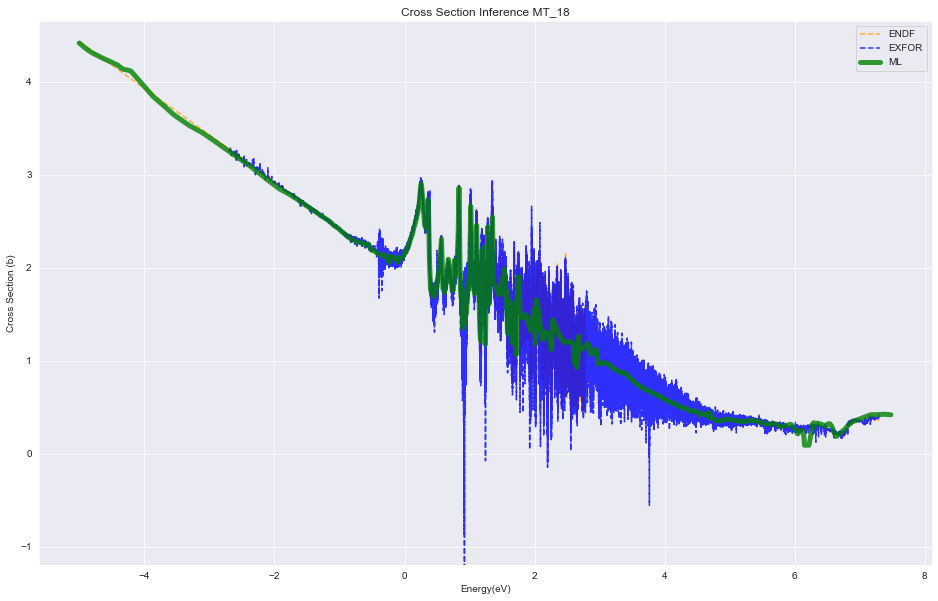

EXFOR VS ML: Original Data
The MSE is:  0.03641926078284661
The MAE is:  0.13187315786351866
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
eTiny_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 59)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


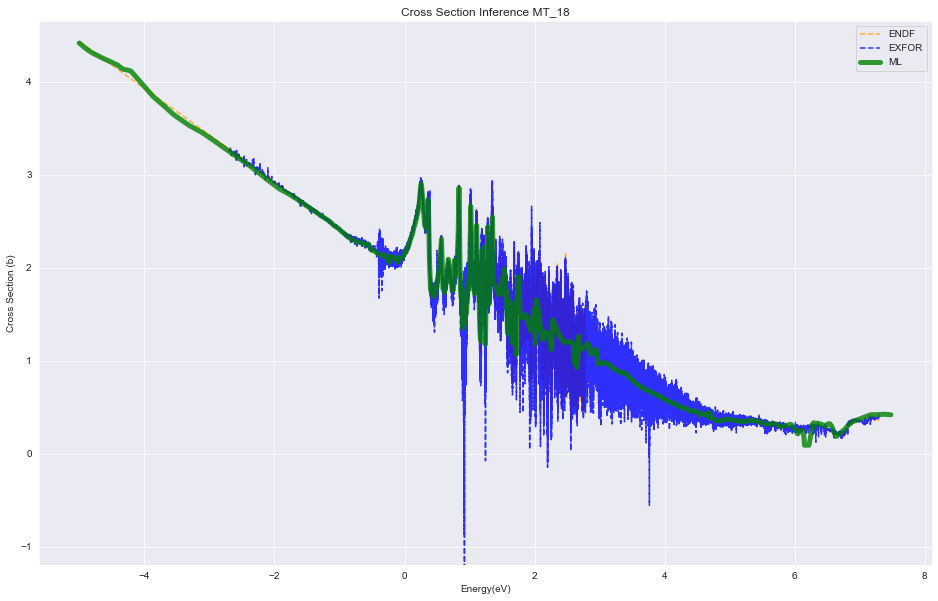

EXFOR VS ML: Original Data
The MSE is:  0.03641926078284661
The MAE is:  0.13187315786351866
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
eTiny_Plateau
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 59)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


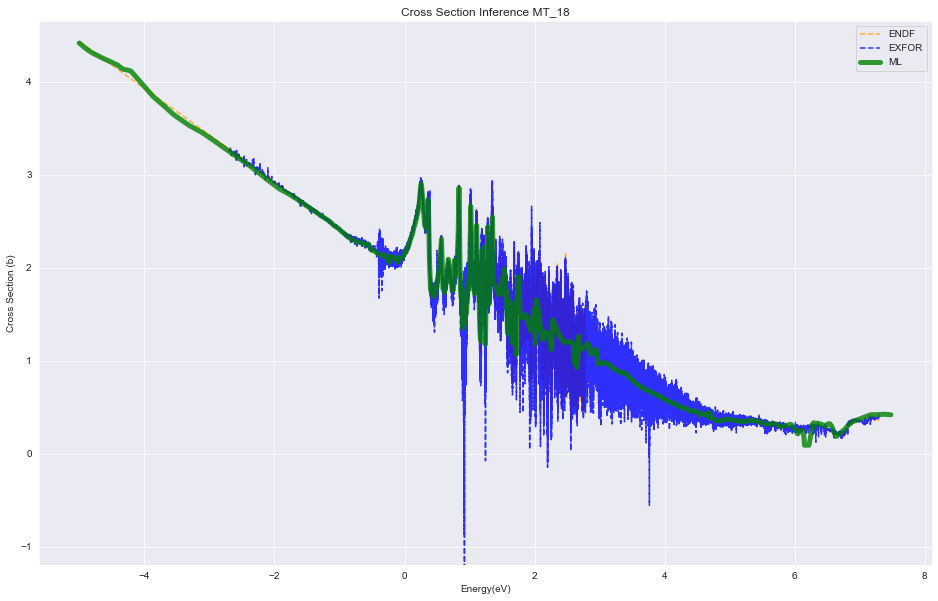

EXFOR VS ML: Original Data
The MSE is:  0.03641926078284661
The MAE is:  0.13187315786351866
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
eMedium_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 59)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


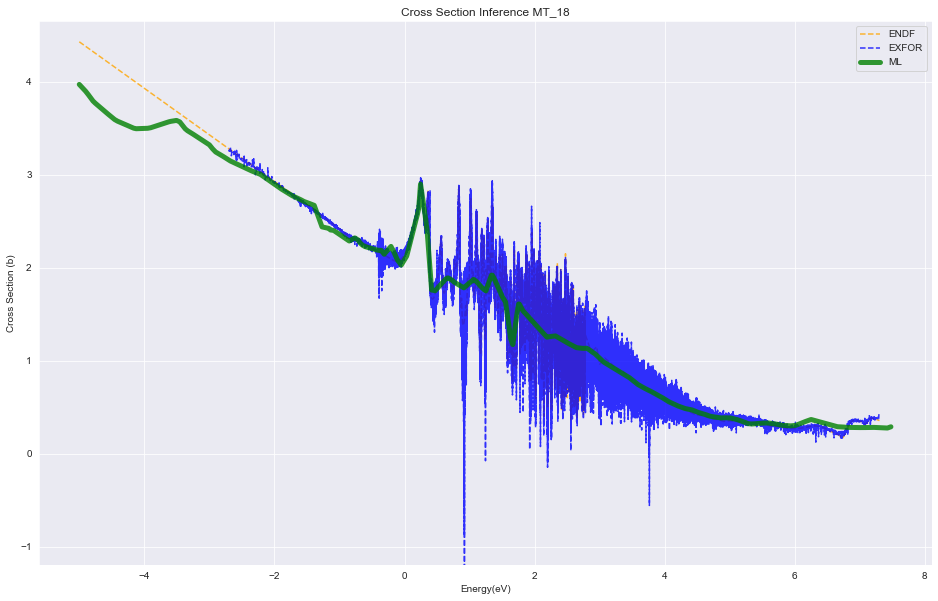

EXFOR VS ML: Original Data
The MSE is:  0.060160366554600955
The MAE is:  0.1743314751726716
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
eLarge_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 59)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


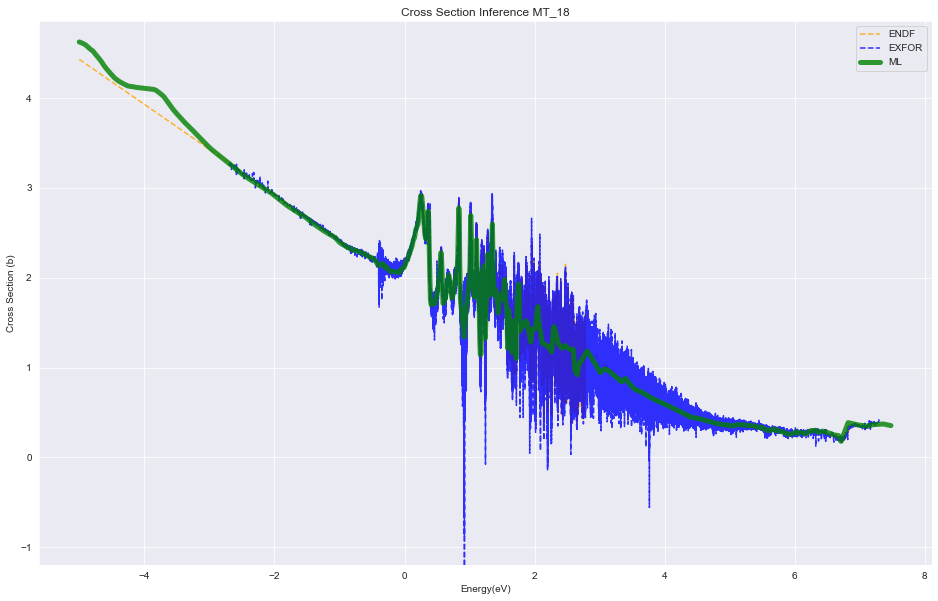

EXFOR VS ML: Original Data
The MSE is:  0.03809167466228051
The MAE is:  0.1348691255295315
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
eLarge_ITD_Exp
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 59)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


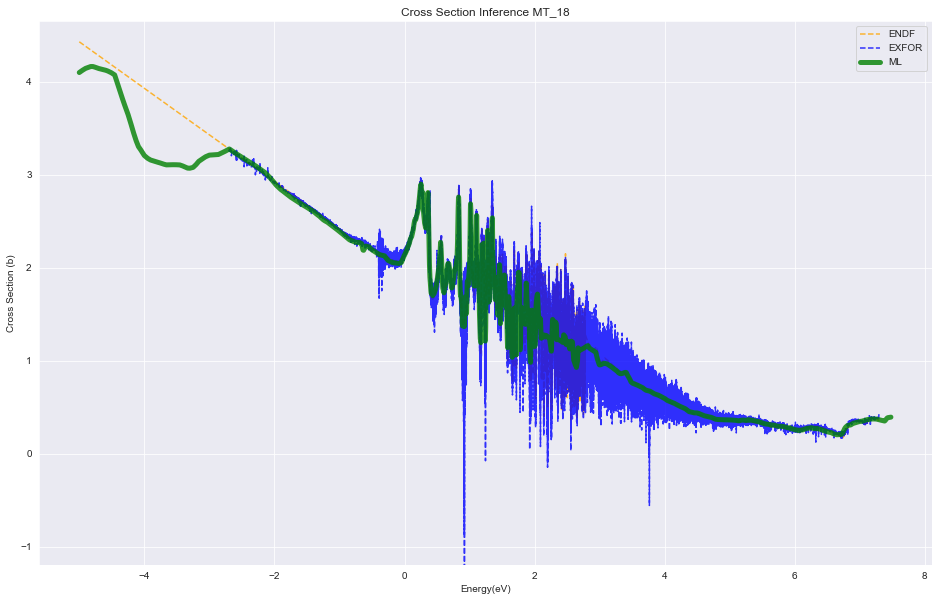

EXFOR VS ML: Original Data
The MSE is:  0.03385473454945335
The MAE is:  0.1252198911279686
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
eLarge_ITD_Exp_2
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 59)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


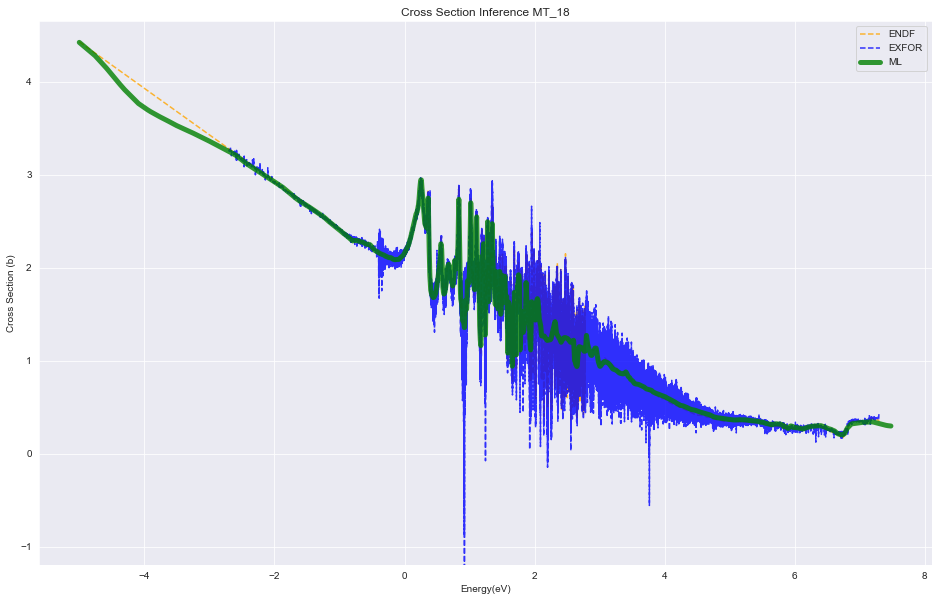

EXFOR VS ML: Original Data
The MSE is:  0.0344541011565098
The MAE is:  0.12638669627846202
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
eLarge_ITD_elu
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 59)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


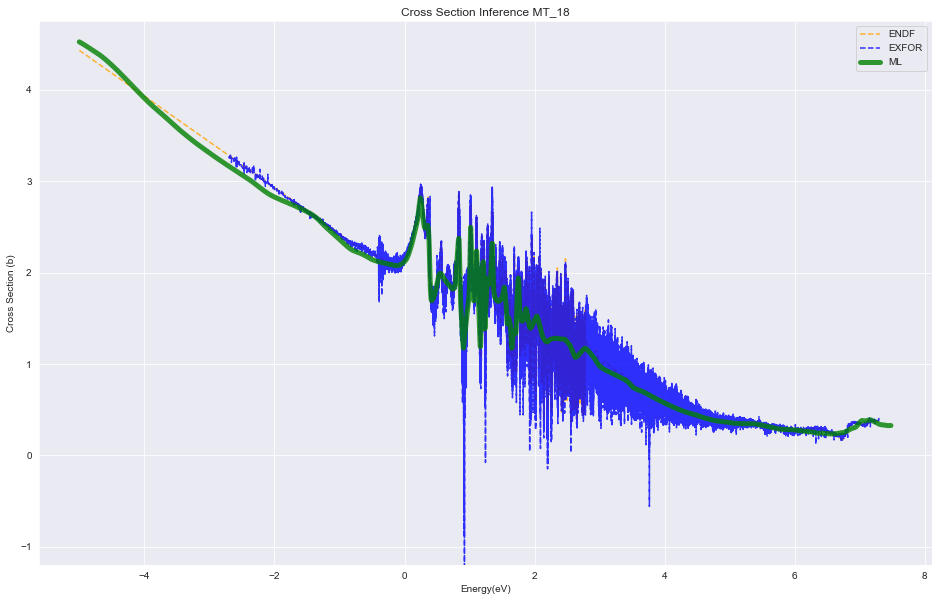

EXFOR VS ML: Original Data
The MSE is:  0.043913259305870034
The MAE is:  0.15045270024365145
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
Tiny_v1
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 59)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


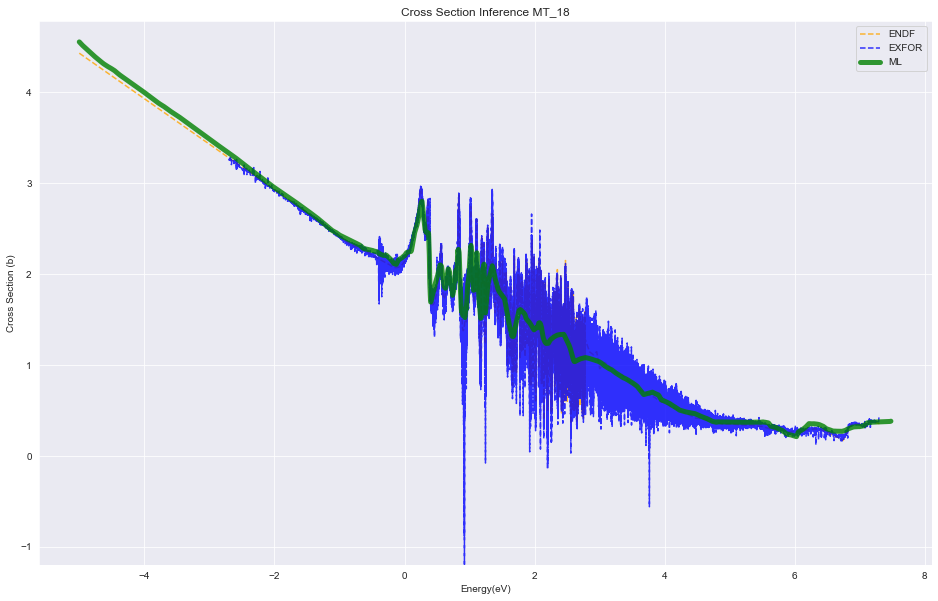

EXFOR VS ML: Original Data
The MSE is:  0.04986509953777396
The MAE is:  0.16102468553012206
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
Tiny_v2
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 59)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


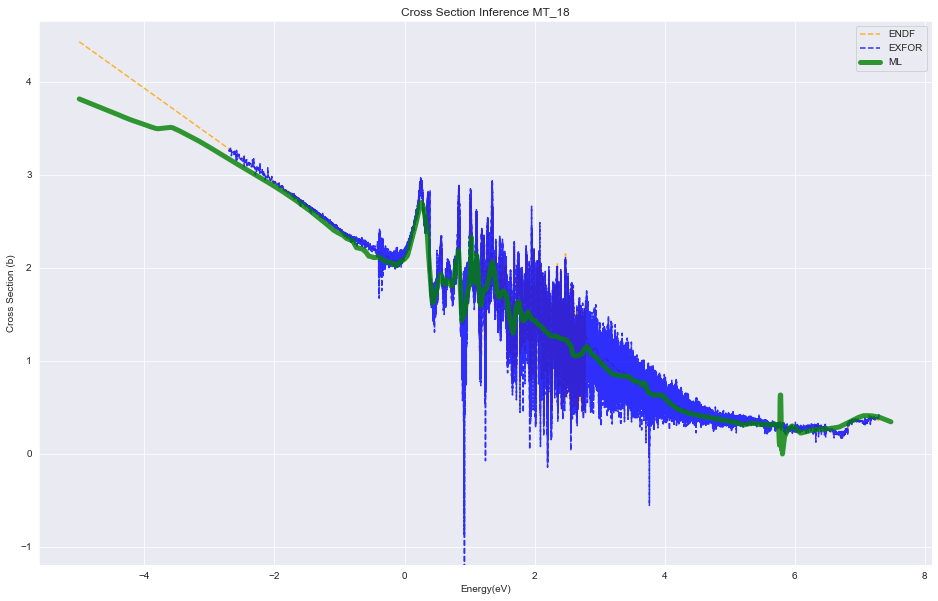

EXFOR VS ML: Original Data
The MSE is:  0.05316717645761691
The MAE is:  0.16674392413997347
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
asym
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 59)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


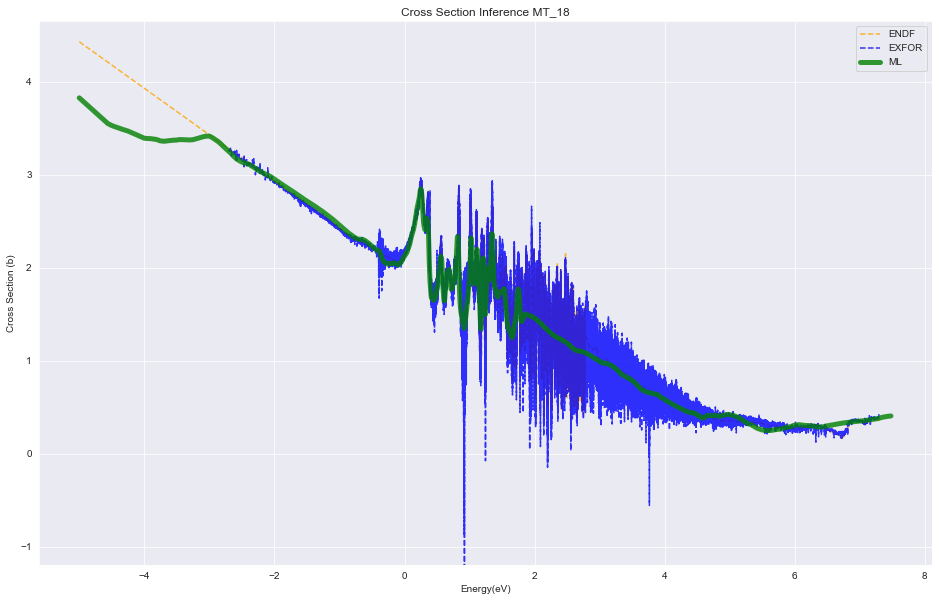

EXFOR VS ML: Original Data
The MSE is:  0.048229754523153194
The MAE is:  0.15732825928682595
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
sym
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 59)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


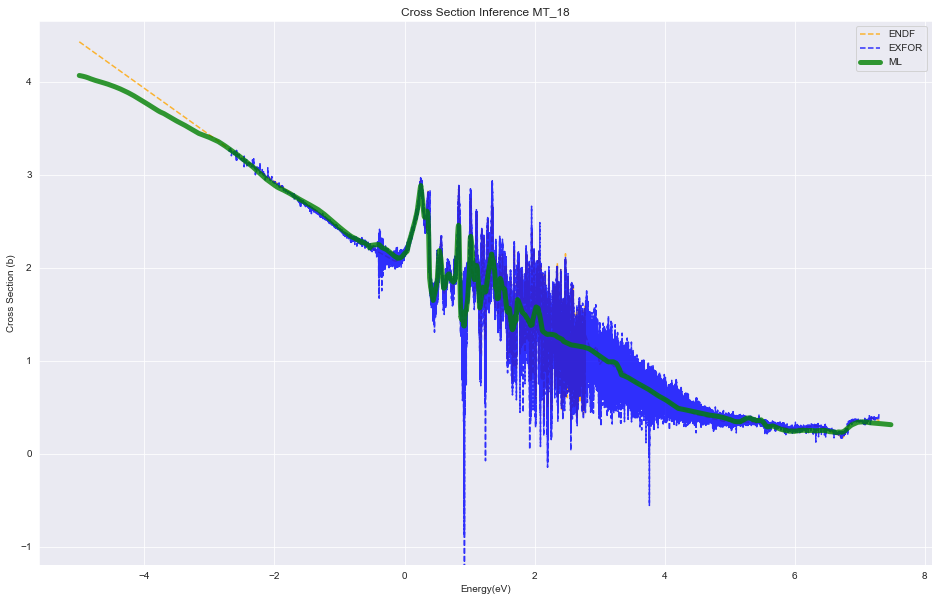

EXFOR VS ML: Original Data
The MSE is:  0.04981135939715916
The MAE is:  0.1591782929421629
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
Tiny_v3
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 59)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


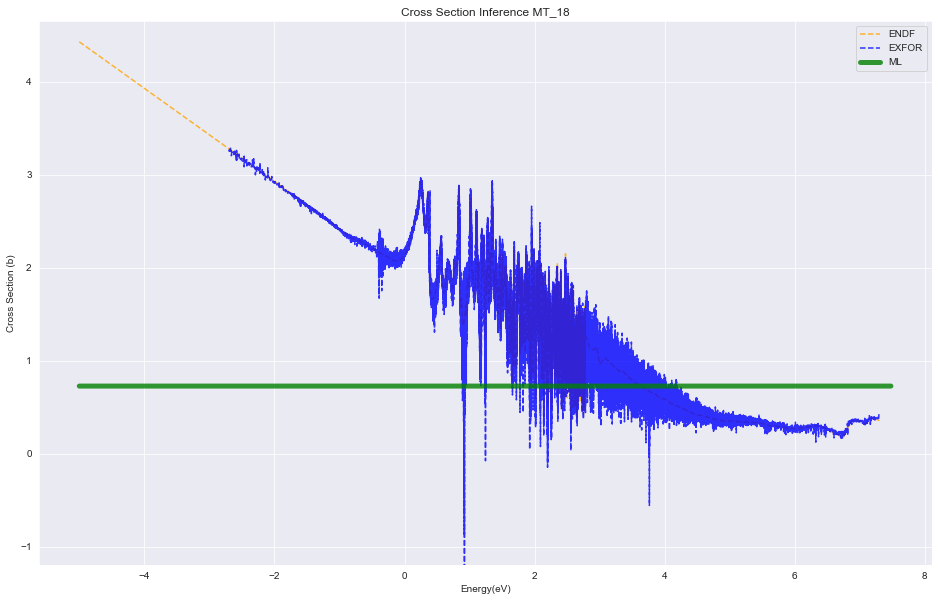

EXFOR VS ML: Original Data
The MSE is:  0.7330962256802604
The MAE is:  0.6877299980312022
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128
eTiny_IDT_v2
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 59)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


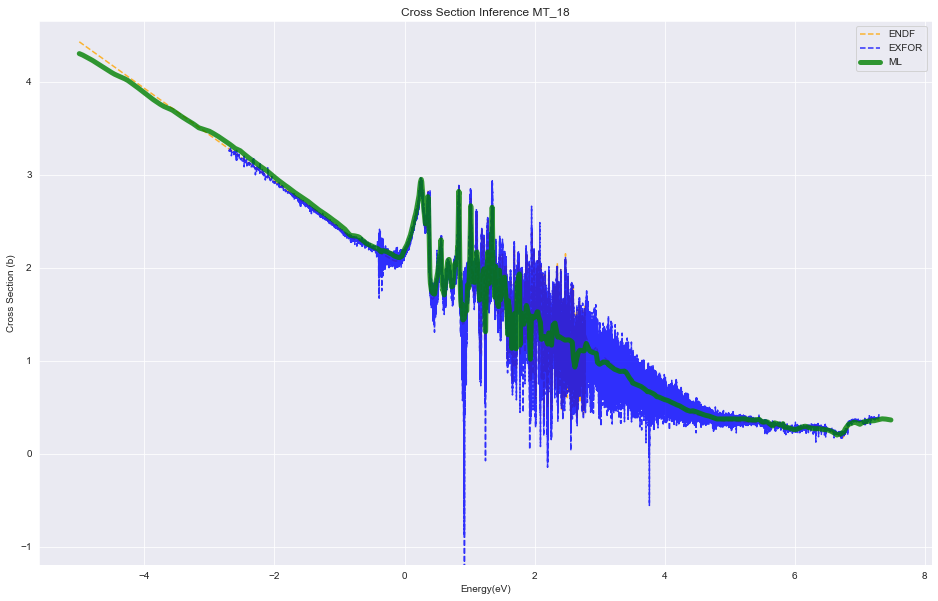

EXFOR VS ML: Original Data
The MSE is:  0.03855565071122445
The MAE is:  0.1373928990035518
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128


In [64]:
for i in histories.keys():
    print(i)
    run_uranium(histories[i].model)

Tiny
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 59)


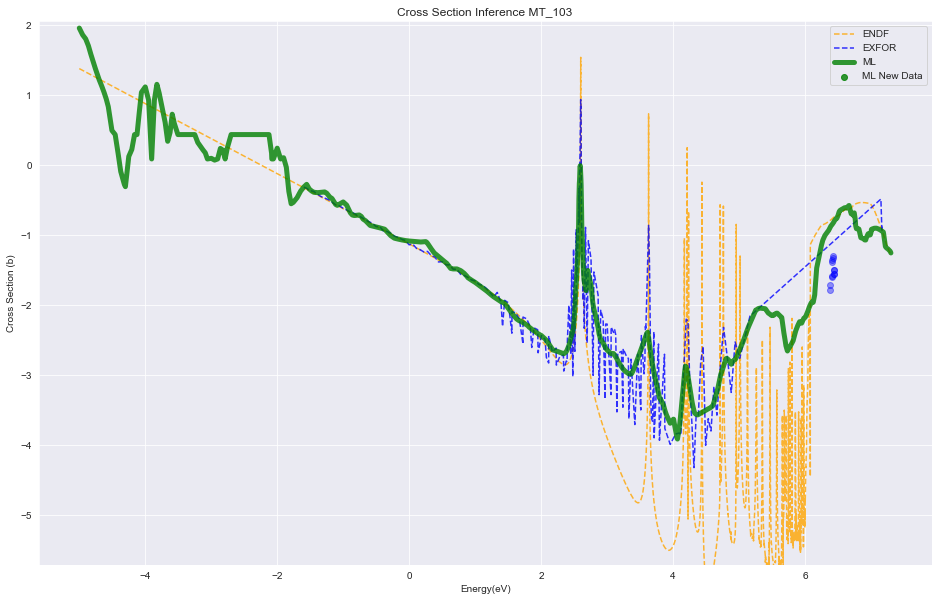

EXFOR VS ML: Original Data
The MSE is:  0.1591105765008731
The MAE is:  0.26367027234167567
EXFOR VS ML: New Data
The MSE is:  5832260662485.821
The MAE is:  2415007.3835260975
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
eTiny_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 59)


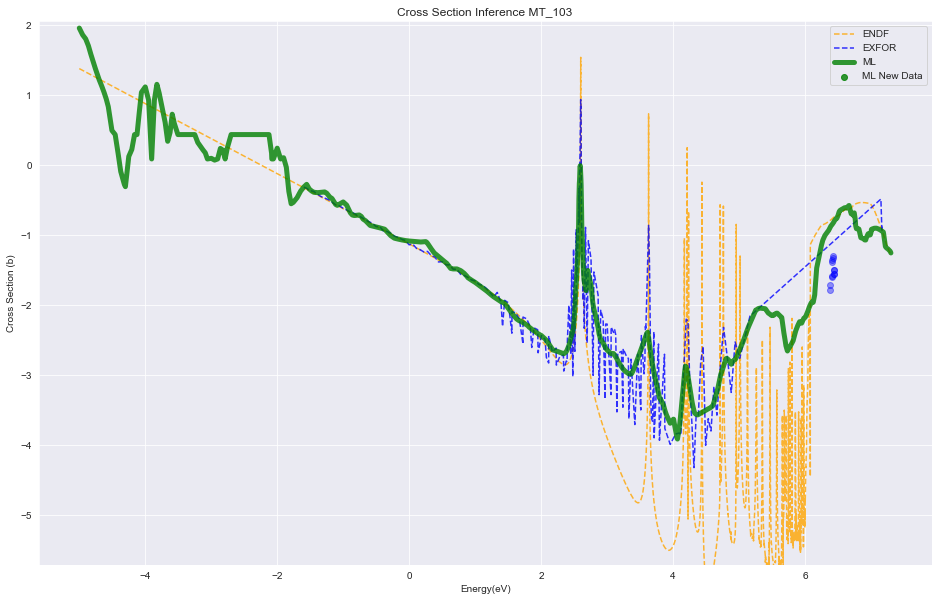

EXFOR VS ML: Original Data
The MSE is:  0.1591105765008731
The MAE is:  0.26367027234167567
EXFOR VS ML: New Data
The MSE is:  5832260662485.821
The MAE is:  2415007.3835260975
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
eTiny_Plateau
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 59)


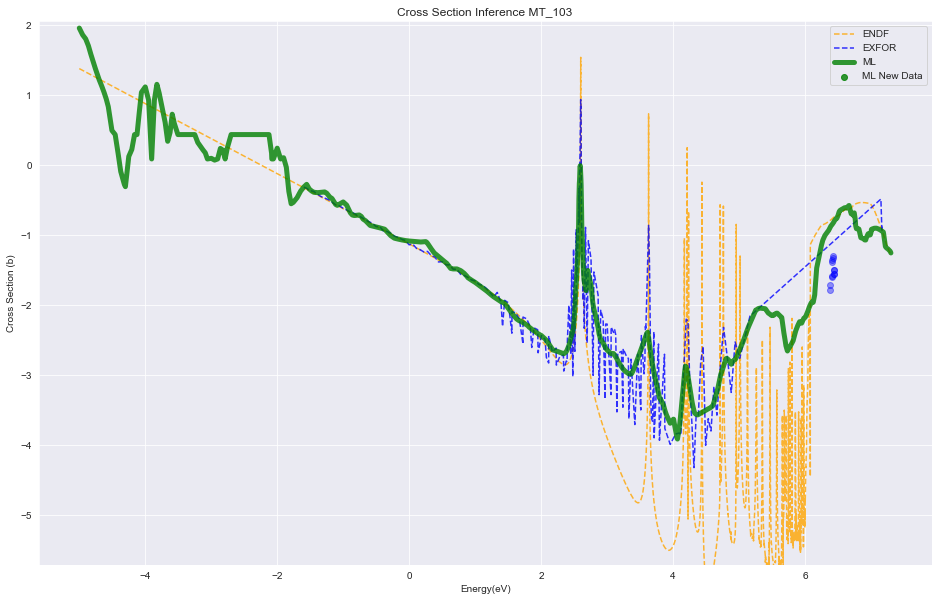

EXFOR VS ML: Original Data
The MSE is:  0.1591105765008731
The MAE is:  0.26367027234167567
EXFOR VS ML: New Data
The MSE is:  5832260662485.821
The MAE is:  2415007.3835260975
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
eMedium_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 59)


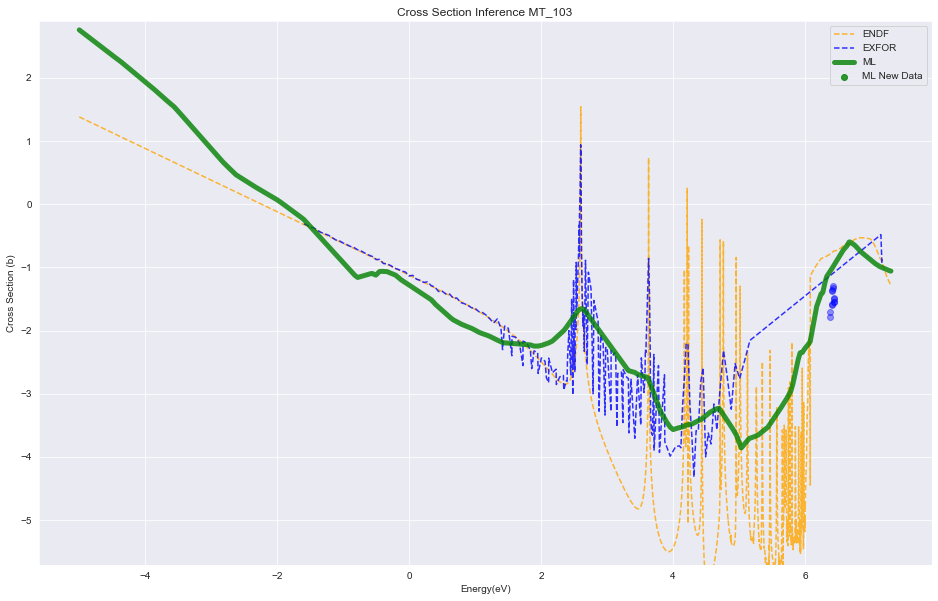

EXFOR VS ML: Original Data
The MSE is:  0.4439644857158446
The MAE is:  0.4834763450970211
EXFOR VS ML: New Data
The MSE is:  176096398647764.38
The MAE is:  13270131.824807236
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
eLarge_ITD
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 59)


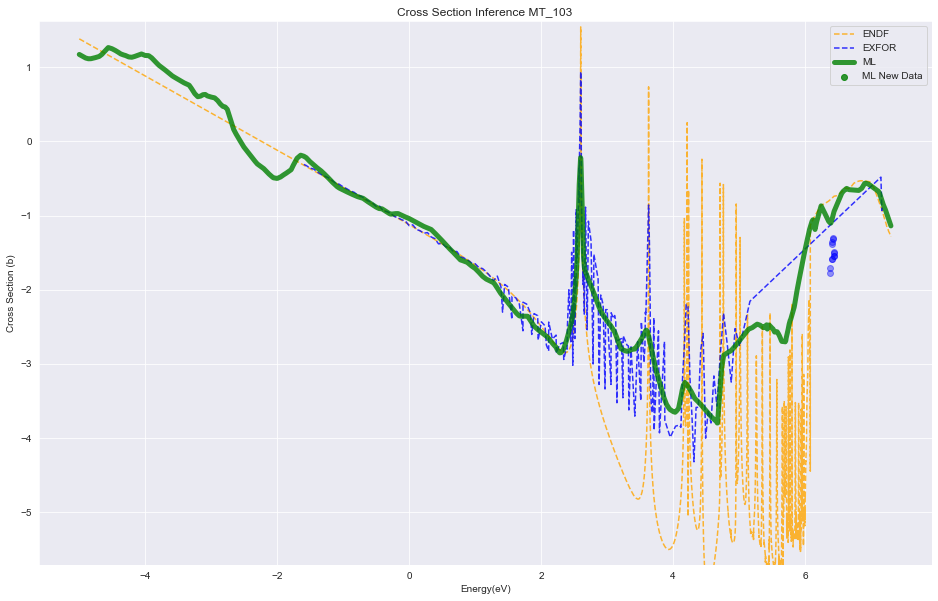

EXFOR VS ML: Original Data
The MSE is:  0.18704877770460238
The MAE is:  0.2915772828686102
EXFOR VS ML: New Data
The MSE is:  4400938748529.923
The MAE is:  2097841.4498072355
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
eLarge_ITD_Exp
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 59)


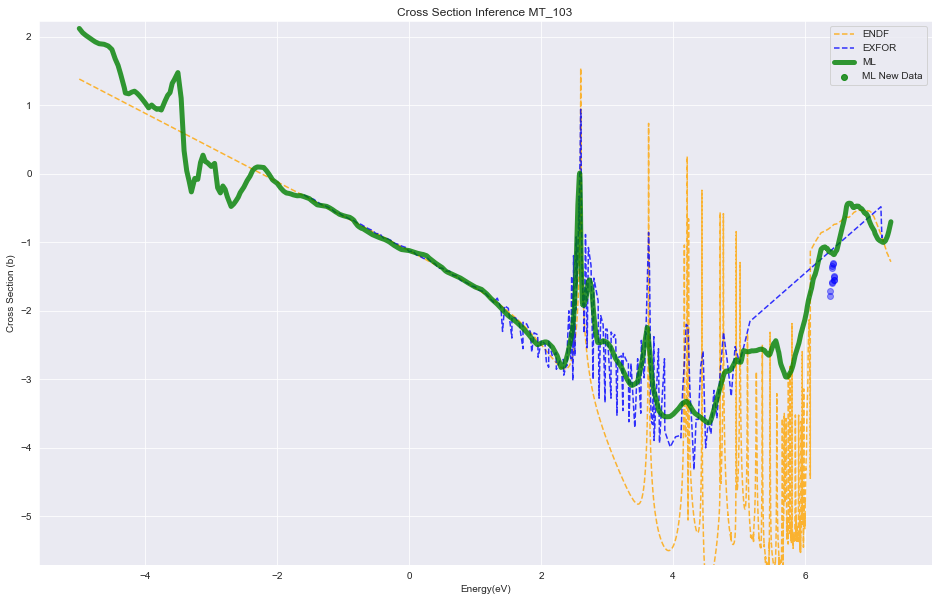

EXFOR VS ML: Original Data
The MSE is:  0.21463049336369341
The MAE is:  0.3127301112987624
EXFOR VS ML: New Data
The MSE is:  20189002166.937637
The MAE is:  142088.0085260976
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
eLarge_ITD_Exp_2
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 59)


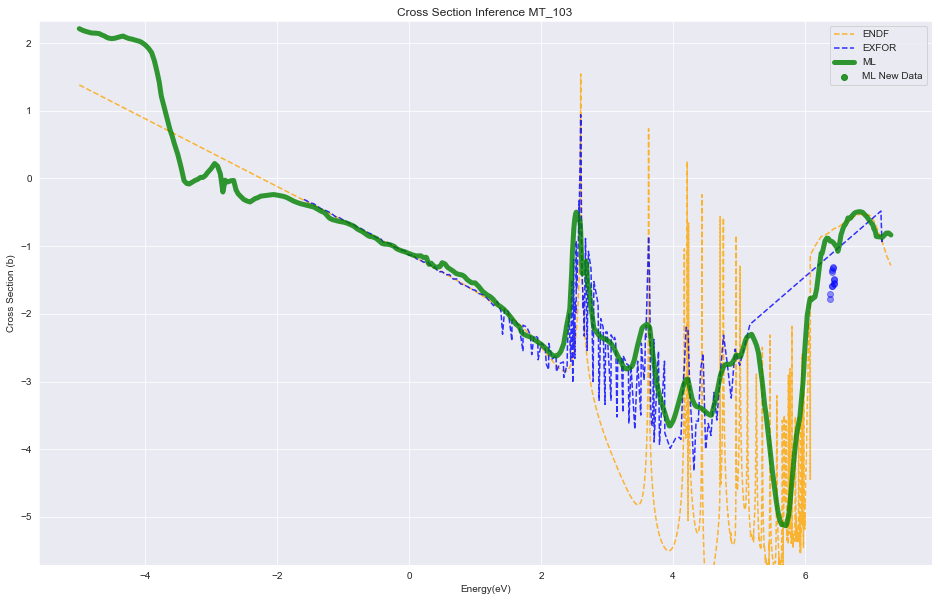

EXFOR VS ML: Original Data
The MSE is:  0.38680957929356186
The MAE is:  0.406645363448667
EXFOR VS ML: New Data
The MSE is:  40519293594.6239
The MAE is:  201294.0475885976
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
eLarge_ITD_elu
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 59)


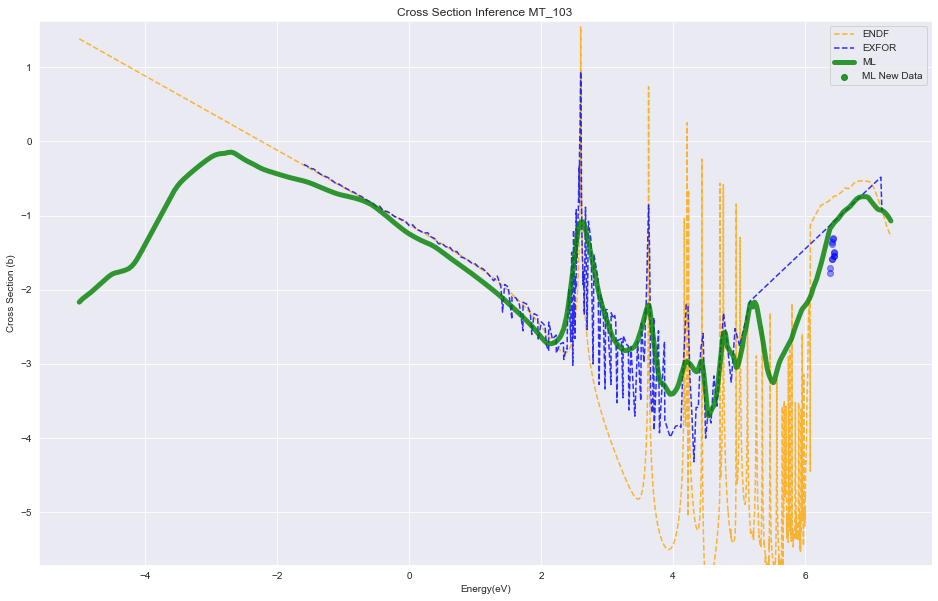

EXFOR VS ML: Original Data
The MSE is:  0.28249287319191135
The MAE is:  0.37346533355241496
EXFOR VS ML: New Data
The MSE is:  6.632927448074503e+18
The MAE is:  2575447038.4914737
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
Tiny_v1
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 59)


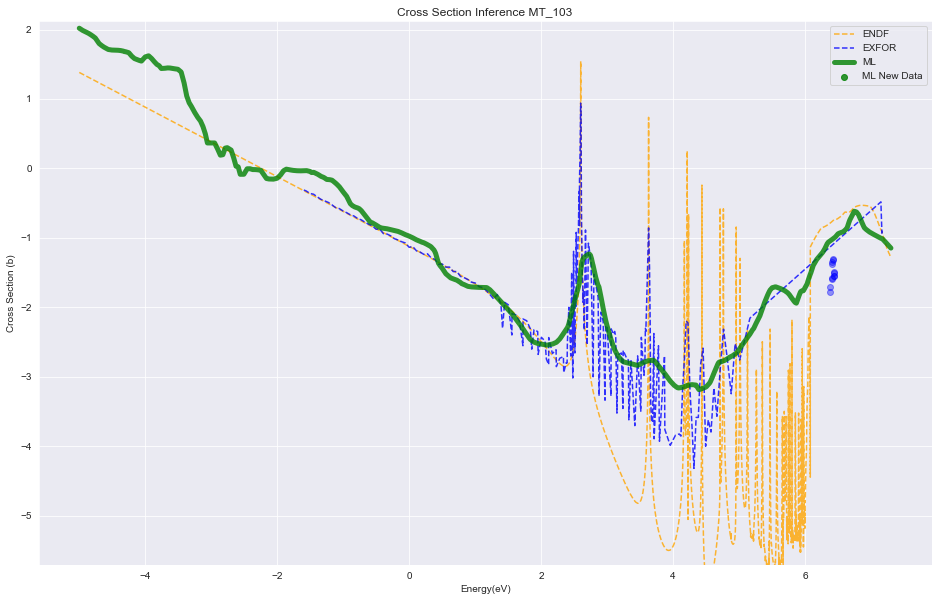

EXFOR VS ML: Original Data
The MSE is:  0.3738216724258658
The MAE is:  0.4154893265703368
EXFOR VS ML: New Data
The MSE is:  1272859994273.7925
The MAE is:  1128210.9706405692
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
Tiny_v2
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 59)


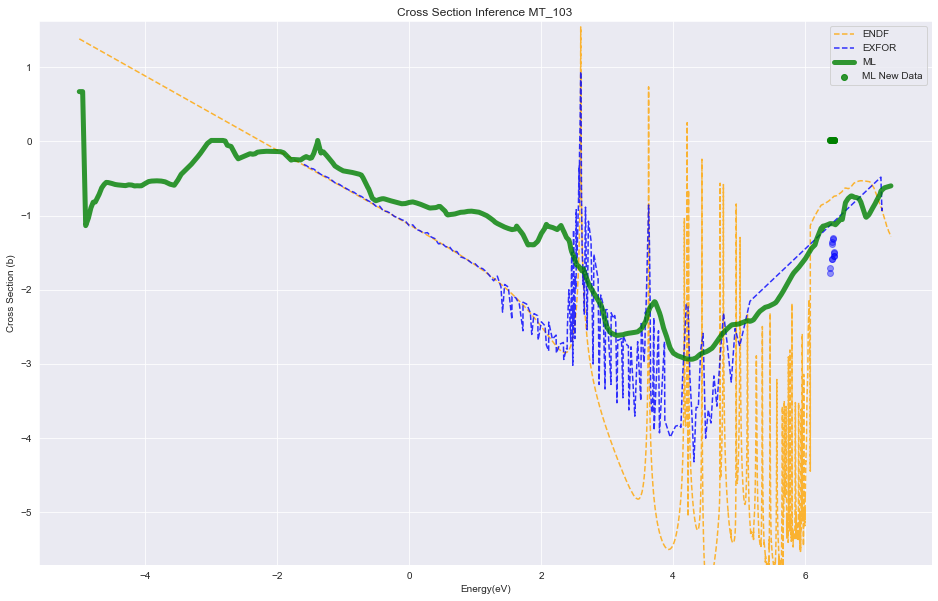

EXFOR VS ML: Original Data
The MSE is:  0.6942892003558624
The MAE is:  0.6501883765218002
EXFOR VS ML: New Data
The MSE is:  2.3353597220771265
The MAE is:  1.521380673723467
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
asym
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 59)


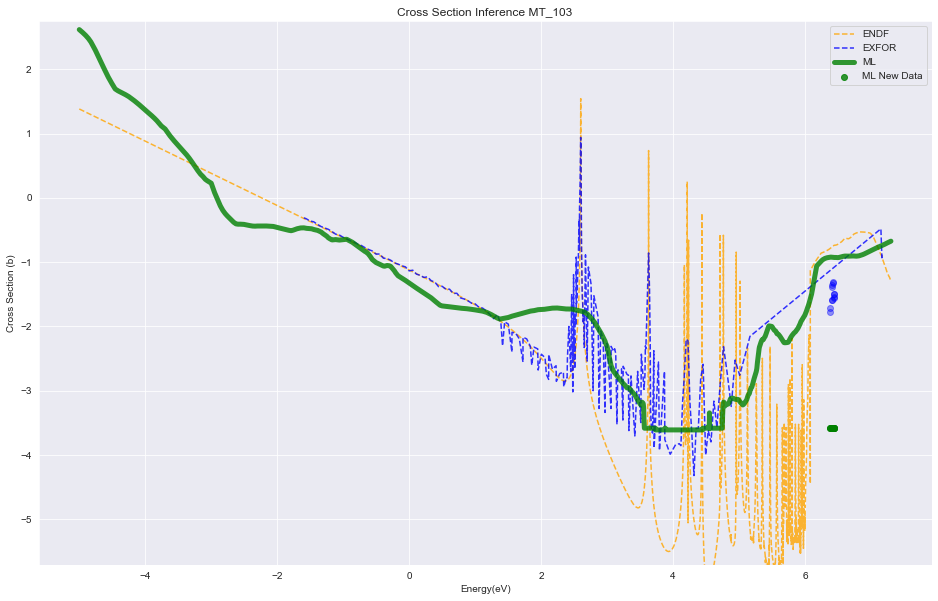

EXFOR VS ML: Original Data
The MSE is:  0.5517352550026821
The MAE is:  0.5194337789444748
EXFOR VS ML: New Data
The MSE is:  4.321511155064273
The MAE is:  2.073825110120527
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
sym
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 59)


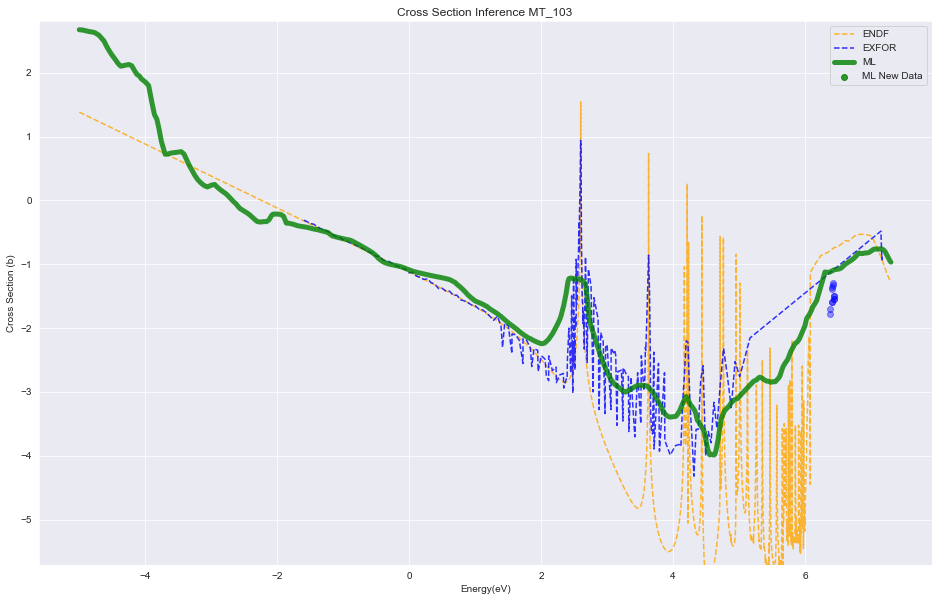

EXFOR VS ML: Original Data
The MSE is:  0.4177838196643
The MAE is:  0.46706409644318553
EXFOR VS ML: New Data
The MSE is:  6684534410.61803
The MAE is:  81759.00201568095
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
Tiny_v3
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 59)


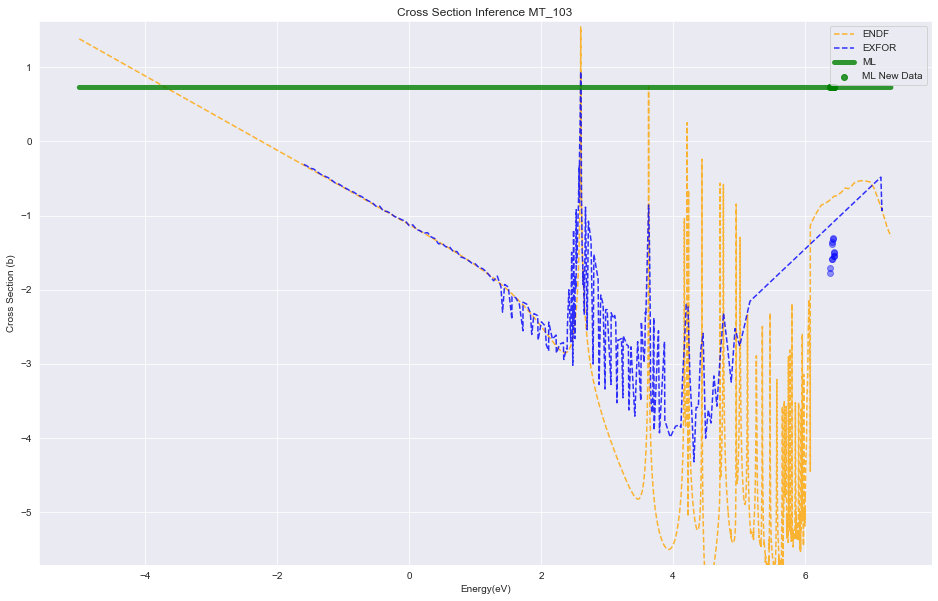

EXFOR VS ML: Original Data
The MSE is:  8.265138208926105
The MAE is:  2.681469358666532
EXFOR VS ML: New Data
The MSE is:  5.018424636678218
The MAE is:  2.23554558642412
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888
eTiny_IDT_v2
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 59)


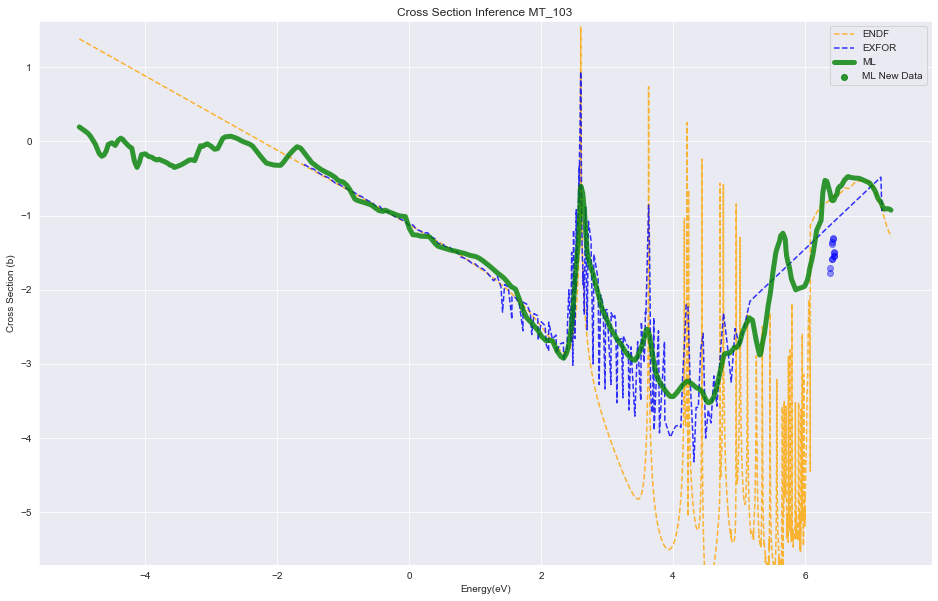

EXFOR VS ML: Original Data
The MSE is:  0.24979093008650696
The MAE is:  0.33985044565369477
EXFOR VS ML: New Data
The MSE is:  74194534870.9879
The MAE is:  272386.7376927642
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888


In [65]:
for i in histories.keys():
    print(i)
    run_chlorine(histories[i].model)

# Trying Hyperparameter Tuning

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [66]:
from tensorboard.plugins.hparams import api as hp

In [135]:
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([500, 800, 1000])) 
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([5, 10]))
HP_NUM_UNITS3 = hp.HParam('num_units 3', hp.Discrete([50, 80, 100])) 

# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#             0.001, decay_steps=STEPS_PER_EPOCH*DECAY_EPOCHS, decay_rate=1)
# tf.keras.optimizers.Adam(lr_schedule)
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))

METRIC_MSE = 'mean_squared_error'
METRIC_MAE = 'mean_absolute_error'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS1, HP_NUM_UNITS2, HP_NUM_UNITS3],
        metrics=[hp.Metric(METRIC_MSE, display_name='Mean Squared Error'), 
                 hp.Metric(METRIC_MAE, display_name="Mean Absolute Error")])

In [136]:
def get_callbacks(name, lr_method="plateau", reset=False):
    logdir = os.path.join("logs", name)
    # logdir = "logs\\" + name + "\\"
    chkpoint_dir = './model_checkpoints/' + name
    if not os.path.exists(chkpoint_dir):
        os.makedirs(chkpoint_dir)
    if not os.path.exists(logdir):
        os.makedirs(logdir)
    if reset:
        filelist = [f for f in os.listdir(chkpoint_dir)]
        for f in filelist:
            os.remove(os.path.join(chkpoint_dir, f))
        if os.path.exists(logdir):
            for filename in os.listdir(logdir):
                shutil.rmtree(os.path.join(logdir, filename))

    filepath = chkpoint_dir + "/model-{epoch:02d}-{loss:.2f}.hdf5"

    if lr_method == "plateau":
        return [
            tfdocs.modeling.EpochDots(),
            tf.keras.callbacks.EarlyStopping(monitor='loss', patience=21), # val_loss
            tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=0,
                                               save_best_only=False, save_weights_only=False,
                                               save_frequency=5),
            tf.keras.callbacks.TensorBoard(log_dir="logs/" + name, histogram_freq=1, profile_batch=0),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='loss', factor=0.8, patience=4, verbose=1, mode='auto',
                min_delta=0.0001, cooldown=0, min_lr=0)]
    elif lr_method == "normal":
        return [
            tfdocs.modeling.EpochDots(),
            tf.keras.callbacks.EarlyStopping(monitor='loss', patience=21), # val_loss
            tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=0,
                                               save_best_only=False, save_weights_only=False,
                                               save_frequency=5),
            tf.keras.callbacks.TensorBoard(log_dir="logs/" + name, histogram_freq=1, profile_batch=0)]
    else:
        return [
            tfdocs.modeling.EpochDots(),
            tf.keras.callbacks.EarlyStopping(monitor='loss', patience=21), # val_loss
            tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=0,
                                               save_best_only=False, save_weights_only=False,
                                               save_frequency=5)]

In [137]:
def train_test_model(hparams):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS1], activation='relu'), 
        tf.keras.layers.Dense(400, activation='relu'),
        tf.keras.layers.Dense(300, activation='relu'), 
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS3], activation='relu'),
        tf.keras.layers.Dense(25, activation='relu'), 
        tf.keras.layers.Dense(15, activation='relu'), 
        tf.keras.layers.Dense(10, activation='relu'), 
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS2], activation='relu'), 
        tf.keras.layers.Dense(1)])


    model.compile(
        optimizer=tf.keras.optimizers.Adam(tf.keras.optimizers.schedules.InverseTimeDecay(
            0.001, decay_steps=STEPS_PER_EPOCH*DECAY_EPOCHS, decay_rate=1)), 
        loss='mse', metrics=['mae', 'mse'])
    
    history = model.fit(
        x_train.values, y_train.values,
        batch_size=BATCH_SIZE,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=100,
        validation_data=(x_test.values, y_test.values),
        callbacks=get_callbacks("hp_tuning", lr_method=None),
        verbose=1, 
        initial_epoch=0)   
    
    _, mae, mse = model.evaluate(x_test.values, y_test.values)

    return mae, mse, history

In [138]:
def run(run_dir, hparams, dictionary, session_num):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        mae, mse, history = train_test_model(hparams)
        dictionary["model_{}".format(session_num)] = history
        tf.summary.scalar(METRIC_MSE, mse, step=1)
        tf.summary.scalar(METRIC_MAE, mae, step=1)

In [139]:
hparams_models = {}

In [140]:
session_num = 0
for num_units1 in HP_NUM_UNITS1.domain.values:
    for num_units2 in HP_NUM_UNITS2.domain.values:
        for num_units3 in HP_NUM_UNITS3.domain.values:
            hparams = {
                HP_NUM_UNITS1: num_units1,
                HP_NUM_UNITS2: num_units2,
                HP_NUM_UNITS3: num_units3,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams, hparams_models, session_num)
            session_num += 1

--- Starting trial: run-0
{'num_units 1': 500, 'num_units 2': 5, 'num_units 3': 50}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763500/3765820 [============================>.] - ETA: 0s - loss: 0.1514 - mae: 0.2429 - mse: 0.1514
Epoch: 0, loss:0.1514,  mae:0.2429,  mse:0.1514,  val_loss:0.1270,  val_mae:0.2176,  val_mse:0.1270,  
3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0802 - mae: 0.1621 - mse: 0.0802 - val_loss: 0.0804 - val_mae: 0.1623 - val_mse: 0.0804Epoch 95/100


418425/418425 [==============================] - 26s 63us/sample - loss: 0.0810 - mae: 0.1629 - mse: 0.0810
--- Starting trial: run-1
{'num_units 1': 500, 'num_units 2': 5, 'num_units 3': 80}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3761000/3765820 [============================>.] - ETA: 0s - loss: 0.1496 - mae: 0.2409 - mse: 0.1496
Epoch: 0, loss:0.1495,  mae:0.2409,  mse:0.1495,  val_loss:0.1280,  val_mae:0.2201,  val_mse:0.1280,  
3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0818 - mae: 0.1640 - mse: 0.0818 - val_loss: 0.0823 - val_mae: 0.1648 - val_mse: 0.0823Epoch 89/100


418425/418425 [==============================] - 26s 63us/sample - loss: 0.0810 - mae: 0.1631 - mse: 0.0810
--- Starting trial: run-2
{'num_units 1': 500, 'num_units 2': 5, 'num_units 3': 100}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765500/3765820 [============================>.] - ETA: 0s - loss: 0.1494 - mae: 0.2410 - mse: 0.1494
Epoch: 0, loss:0.1494,  mae:0.2410,  mse:0.1494,  val_loss:0.1303,  val_mae:0.2254,  val_mse:0.1303,  
3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0809 - mae: 0.1628 - mse: 0.0809 - val_loss: 0.0815 - val_mae: 0.1632 - val_mse: 0.0815Epoch 83/100


418425/418425 [==============================] - 27s 65us/sample - loss: 0.0803 - mae: 0.1620 - mse: 0.0803
--- Starting trial: run-3
{'num_units 1': 500, 'num_units 2': 10, 'num_units 3': 50}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3762000/3765820 [============================>.] - ETA: 0s - loss: 0.1559 - mae: 0.2464 - mse: 0.1559
Epoch: 0, loss:0.1559,  mae:0.2464,  mse:0.1559,  val_loss:0.1293,  val_mae:0.2215,  val_mse:0.1293,  
3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0833 - mae: 0.1657 - mse: 0.0833 - val_loss: 0.0831 - val_mae: 0.1656 - val_mse: 0.0831Epoch 77/100


418425/418425 [==============================] - 33s 79us/sample - loss: 0.0818 - mae: 0.1637 - mse: 0.0818
--- Starting trial: run-4
{'num_units 1': 500, 'num_units 2': 10, 'num_units 3': 80}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3765500/3765820 [============================>.] - ETA: 0s - loss: 0.1515 - mae: 0.2436 - mse: 0.1515
Epoch: 0, loss:0.1515,  mae:0.2436,  mse:0.1515,  val_loss:0.1290,  val_mae:0.2222,  val_mse:0.1290,  
3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0825 - mae: 0.1650 - mse: 0.0825 - val_loss: 0.0828 - val_mae: 0.1656 - val_mse: 0.0828Epoch 71/100


418425/418425 [==============================] - 34s 81us/sample - loss: 0.0800 - mae: 0.1619 - mse: 0.0800
--- Starting trial: run-5
{'num_units 1': 500, 'num_units 2': 10, 'num_units 3': 100}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764500/3765820 [============================>.] - ETA: 0s - loss: 0.1510 - mae: 0.2425 - mse: 0.1510
Epoch: 0, loss:0.1510,  mae:0.2425,  mse:0.1510,  val_loss:0.1271,  val_mae:0.2199,  val_mse:0.1271,  
3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0835 - mae: 0.1663 - mse: 0.0835 - val_loss: 0.0837 - val_mae: 0.1670 - val_mse: 0.0837Epoch 65/100


418425/418425 [==============================] - 32s 77us/sample - loss: 0.0800 - mae: 0.1619 - mse: 0.0800
--- Starting trial: run-6
{'num_units 1': 800, 'num_units 2': 5, 'num_units 3': 50}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3761500/3765820 [============================>.] - ETA: 0s - loss: 0.1549 - mae: 0.2458 - mse: 0.1549
Epoch: 0, loss:0.1549,  mae:0.2458,  mse:0.1549,  val_loss:0.1322,  val_mae:0.2245,  val_mse:0.1322,  
3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0845 - mae: 0.1672 - mse: 0.0845 - val_loss: 0.0842 - val_mae: 0.1672 - val_mse: 0.0842Epoch 59/100


418425/418425 [==============================] - 31s 75us/sample - loss: 0.0804 - mae: 0.1619 - mse: 0.0804
--- Starting trial: run-7
{'num_units 1': 800, 'num_units 2': 5, 'num_units 3': 80}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764500/3765820 [============================>.] - ETA: 0s - loss: 0.1524 - mae: 0.2443 - mse: 0.1524
Epoch: 0, loss:0.1524,  mae:0.2442,  mse:0.1524,  val_loss:0.1300,  val_mae:0.2242,  val_mse:0.1300,  
3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0863 - mae: 0.1698 - mse: 0.0863 - val_loss: 0.0863 - val_mae: 0.1698 - val_mse: 0.0863Epoch 53/100


418425/418425 [==============================] - 32s 76us/sample - loss: 0.0811 - mae: 0.1630 - mse: 0.0811
--- Starting trial: run-8
{'num_units 1': 800, 'num_units 2': 5, 'num_units 3': 100}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100


3765000/3765820 [============================>.] - ETA: 0s - loss: 0.1551 - mae: 0.2462 - mse: 0.1551
Epoch: 0, loss:0.1551,  mae:0.2462,  mse:0.1551,  val_loss:0.1347,  val_mae:0.2287,  val_mse:0.1347,  
3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0805 - mae: 0.1624 - mse: 0.0805 - val_loss: 0.0805 - val_mae: 0.1627 - val_mse: 0.0805Epoch 96/100


418425/418425 [==============================] - 31s 74us/sample - loss: 0.0814 - mae: 0.1634 - mse: 0.0814
--- Starting trial: run-9
{'num_units 1': 800, 'num_units 2': 10, 'num_units 3': 50}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3760500/3765820 [============================>.] - ETA: 0s - loss: 0.1705 - mae: 0.2572 - mse: 0.1705
Epoch: 0, loss:0.1704,  mae:0.2572,  mse:0.1704,  val_loss:0.1391,  val_mae:0.2299,  val_mse:0.1391,  
3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0840 - mae: 0.1669 - mse: 0.0840 - val_loss: 0.0845 - val_mae: 0.1678 - val_mse: 0.0845Epoch 90/100


418425/418425 [==============================] - 31s 74us/sample - loss: 0.0830 - mae: 0.1656 - mse: 0.0830
--- Starting trial: run-10
{'num_units 1': 800, 'num_units 2': 10, 'num_units 3': 80}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3760500/3765820 [============================>.] - ETA: 0s - loss: 0.1539 - mae: 0.2448 - mse: 0.1539
Epoch: 0, loss:0.1538,  mae:0.2448,  mse:0.1538,  val_loss:0.1315,  val_mae:0.2273,  val_mse:0.1315,  
3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0820 - mae: 0.1641 - mse: 0.0820 - val_loss: 0.0869 - val_mae: 0.1714 - val_mse: 0.0869Epoch 84/100


418425/418425 [==============================] - 31s 74us/sample - loss: 0.0810 - mae: 0.1630 - mse: 0.0810
--- Starting trial: run-11
{'num_units 1': 800, 'num_units 2': 10, 'num_units 3': 100}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763500/3765820 [============================>.] - ETA: 0s - loss: 0.1530 - mae: 0.2443 - mse: 0.1530
Epoch: 0, loss:0.1530,  mae:0.2443,  mse:0.1530,  val_loss:0.1329,  val_mae:0.2267,  val_mse:0.1329,  
3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0820 - mae: 0.1645 - mse: 0.0820 - val_loss: 0.0836 - val_mae: 0.1667 - val_mse: 0.0836Epoch 78/100


418425/418425 [==============================] - 31s 75us/sample - loss: 0.0806 - mae: 0.1623 - mse: 0.0806
--- Starting trial: run-12
{'num_units 1': 1000, 'num_units 2': 5, 'num_units 3': 50}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3761000/3765820 [============================>.] - ETA: 0s - loss: 0.1529 - mae: 0.2447 - mse: 0.1529
Epoch: 0, loss:0.1529,  mae:0.2446,  mse:0.1529,  val_loss:0.1295,  val_mae:0.2237,  val_mse:0.1295,  
3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0828 - mae: 0.1654 - mse: 0.0828 - val_loss: 0.0839 - val_mae: 0.1669 - val_mse: 0.0839Epoch 72/100


418425/418425 [==============================] - 31s 75us/sample - loss: 0.0814 - mae: 0.1636 - mse: 0.0814
--- Starting trial: run-13
{'num_units 1': 1000, 'num_units 2': 5, 'num_units 3': 80}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763000/3765820 [============================>.] - ETA: 0s - loss: 0.1858 - mae: 0.2592 - mse: 0.1858
Epoch: 0, loss:0.1858,  mae:0.2592,  mse:0.1858,  val_loss:0.1513,  val_mae:0.2492,  val_mse:0.1513,  
3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0862 - mae: 0.1698 - mse: 0.0862 - val_loss: 0.0871 - val_mae: 0.1713 - val_mse: 0.0871Epoch 66/100


418425/418425 [==============================] - 31s 75us/sample - loss: 0.0837 - mae: 0.1659 - mse: 0.0837
--- Starting trial: run-14
{'num_units 1': 1000, 'num_units 2': 5, 'num_units 3': 100}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3760500/3765820 [============================>.] - ETA: 0s - loss: 0.1506 - mae: 0.2418 - mse: 0.1506
Epoch: 0, loss:0.1505,  mae:0.2418,  mse:0.1505,  val_loss:0.1278,  val_mae:0.2172,  val_mse:0.1278,  
3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0839 - mae: 0.1668 - mse: 0.0839 - val_loss: 0.0839 - val_mae: 0.1675 - val_mse: 0.0839Epoch 60/100


418425/418425 [==============================] - 32s 76us/sample - loss: 0.0799 - mae: 0.1618 - mse: 0.0799
--- Starting trial: run-15
{'num_units 1': 1000, 'num_units 2': 10, 'num_units 3': 50}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3763000/3765820 [============================>.] - ETA: 0s - loss: 0.1535 - mae: 0.2450 - mse: 0.1535
Epoch: 0, loss:0.1535,  mae:0.2450,  mse:0.1535,  val_loss:0.1305,  val_mae:0.2240,  val_mse:0.1305,  
3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0855 - mae: 0.1689 - mse: 0.0855 - val_loss: 0.0860 - val_mae: 0.1695 - val_mse: 0.0860Epoch 54/100


418425/418425 [==============================] - 31s 75us/sample - loss: 0.0813 - mae: 0.1632 - mse: 0.0813
--- Starting trial: run-16
{'num_units 1': 1000, 'num_units 2': 10, 'num_units 3': 80}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3764000/3765820 [============================>.] - ETA: 0s - loss: 0.1531 - mae: 0.2440 - mse: 0.1531
Epoch: 0, loss:0.1531,  mae:0.2440,  mse:0.1531,  val_loss:0.1293,  val_mae:0.2250,  val_mse:0.1293,  


3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0807 - mae: 0.1629 - mse: 0.0807 - val_loss: 0.0814 - val_mae: 0.1634 - val_mse: 0.0814Epoch 97/100


418425/418425 [==============================] - 32s 76us/sample - loss: 0.0814 - mae: 0.1639 - mse: 0.0814
--- Starting trial: run-17
{'num_units 1': 1000, 'num_units 2': 10, 'num_units 3': 100}
Train on 3765820 samples, validate on 418425 samples
Epoch 1/100
3762500/3765820 [============================>.] - ETA: 0s - loss: 0.1534 - mae: 0.2444 - mse: 0.1534
Epoch: 0, loss:0.1534,  mae:0.2444,  mse:0.1534,  val_loss:0.1333,  val_mae:0.2273,  val_mse:0.1333,  
3765320/3765820 [============================>.] - ETA: 0s - loss: 0.0800 - mae: 0.1616 - mse: 0.0800 - val_loss: 0.0799 - val_mae: 0.1617 - val_mse: 0.0799Epoch 91/100


418425/418425 [==============================] - 31s 74us/sample - loss: 0.0797 - mae: 0.1612 - mse: 0.0797


Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 59)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


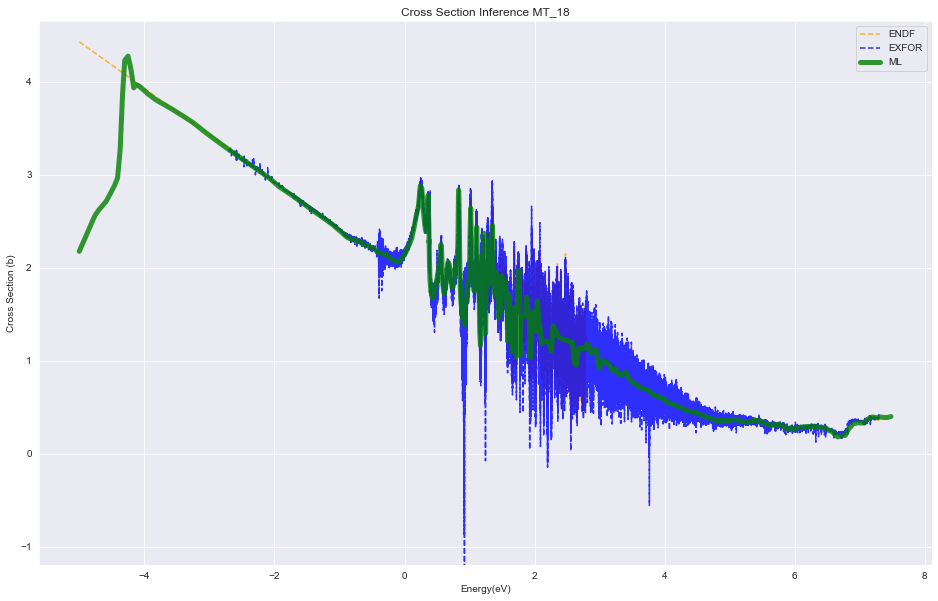

EXFOR VS ML: Original Data
The MSE is:  0.03611394872040473
The MAE is:  0.1318615614471994
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128


In [148]:
run_uranium(hparams_models["model_17"].model)

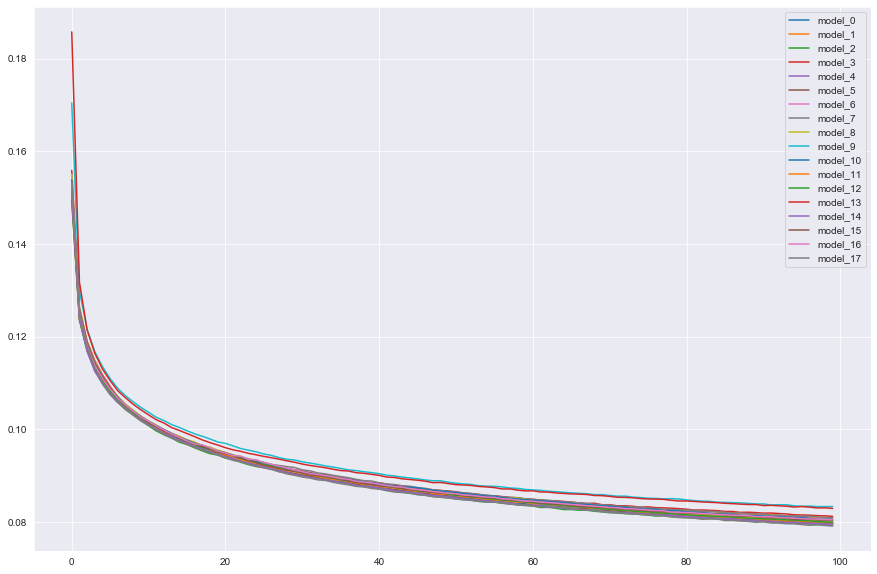

In [153]:
plt.figure(figsize=(15,10))
for i in hparams_models.keys():
    plt.plot(hparams_models[i].epoch, hparams_models[i].history["loss"], label=i)
plt.legend()

In [156]:
for num_layers_to_try in np.linspace(1,5, 5, dtype=int): # FOR 1 TO 5 LAYERS   
    for num_units in [100, 200, 300, 400, 500]:  # FOR 100 TO 500 NEURONS
        model = tf.keras.Sequential()    # INITIALIZE MODEL
        for num_layers in np.linspace(1, num_layers_to_try, num_layers_to_try, dtype=int):
            model.add(tf.keras.layers.Dense(num_units, activation='relu'))
        model.add(tf.keras.layers.Dense(1))
        
        model.build((None, 58))
        model.summary()
        
        histories['{}_Layers_{}_Units_E'.format(num_layers_to_try, num_units)] = model_tools.compile_and_fit(
            model, '{}_Layers_{}_Units_E'.format(num_layers_to_try, num_units), 
            x_train.values, y_train.values, x_test.values, y_test.values, 
            BATCH_SIZE=300, max_epochs=100, DECAY_EPOCHS=10, lr_method="ITD")

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_507 (Dense)            multiple                  5900      
_________________________________________________________________
dense_508 (Dense)            multiple                  101       
Total params: 6,001
Trainable params: 6,001
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:0.1947,  mae:0.2810,  mse:0.1947,  val_loss:0.1647,  val_mae:0.2581,  val_mse:0.1647,  
....................................................................................................Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_509 (Dense)            multiple                  11800     
_________________________________________________________________
dense_510 (Dense)     


Epoch: 0, loss:0.1517,  mae:0.2459,  mse:0.1517,  val_loss:0.1327,  val_mae:0.2294,  val_mse:0.1327,  
....................................................................................................Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_532 (Dense)            multiple                  5900      
_________________________________________________________________
dense_533 (Dense)            multiple                  10100     
_________________________________________________________________
dense_534 (Dense)            multiple                  10100     
_________________________________________________________________
dense_535 (Dense)            multiple                  101       
Total params: 26,201
Trainable params: 26,201
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:0.1543,  mae:0.2482,  mse:0


Epoch: 0, loss:0.1450,  mae:0.2374,  mse:0.1450,  val_loss:0.1268,  val_mae:0.2179,  val_mse:0.1268,  
....................................................................................................Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_567 (Dense)            multiple                  23600     
_________________________________________________________________
dense_568 (Dense)            multiple                  160400    
_________________________________________________________________
dense_569 (Dense)            multiple                  160400    
_________________________________________________________________
dense_570 (Dense)            multiple                  160400    
_________________________________________________________________
dense_571 (Dense)            multiple                  401       
Total params: 505,201
Trainable params: 505,201


Epoch: 0, loss:0.1451,  mae:0.2369,  mse:0.1451,  val_loss:0.1263,  val_mae:0.2157,  val_mse:0.1263,  
....................................................................................................

In [158]:
for num_layers_to_try in np.linspace(6,10, 5, dtype=int): # FOR 1 TO 5 LAYERS   
    for num_units in [600, 700, 800, 900, 1000]:  # FOR 100 TO 500 NEURONS
        model = tf.keras.Sequential()    # INITIALIZE MODEL
        for num_layers in np.linspace(1, num_layers_to_try, num_layers_to_try, dtype=int):
            model.add(tf.keras.layers.Dense(num_units, activation='relu'))
        model.add(tf.keras.layers.Dense(1))
        
        model.build((None, 58))
        model.summary()
        
        histories['{}_Layers_{}_Units_E'.format(num_layers_to_try, num_units)] = model_tools.compile_and_fit(
            model, '{}_Layers_{}_Units_E'.format(num_layers_to_try, num_units), 
            x_train.values, y_train.values, x_test.values, y_test.values, 
            BATCH_SIZE=300, max_epochs=100, DECAY_EPOCHS=10, lr_method="ITD")

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_614 (Dense)            multiple                  35400     
_________________________________________________________________
dense_615 (Dense)            multiple                  360600    
_________________________________________________________________
dense_616 (Dense)            multiple                  360600    
_________________________________________________________________
dense_617 (Dense)            multiple                  360600    
_________________________________________________________________
dense_618 (Dense)            multiple                  360600    
_________________________________________________________________
dense_619 (Dense)            multiple                  360600    
_________________________________________________________________
dense_620 (Dense)            multiple                


Epoch: 0, loss:0.1463,  mae:0.2376,  mse:0.1463,  val_loss:0.1275,  val_mae:0.2185,  val_mse:0.1275,  
....................................................................................................Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_657 (Dense)            multiple                  41300     
_________________________________________________________________
dense_658 (Dense)            multiple                  490700    
_________________________________________________________________
dense_659 (Dense)            multiple                  490700    
_________________________________________________________________
dense_660 (Dense)            multiple                  490700    
_________________________________________________________________
dense_661 (Dense)            multiple                  490700    
_______________________________________________


Epoch: 0, loss:0.1476,  mae:0.2387,  mse:0.1476,  val_loss:0.1284,  val_mae:0.2186,  val_mse:0.1284,  
....................................................................................................Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_698 (Dense)            multiple                  41300     
_________________________________________________________________
dense_699 (Dense)            multiple                  490700    
_________________________________________________________________
dense_700 (Dense)            multiple                  490700    
_________________________________________________________________
dense_701 (Dense)            multiple                  490700    
_________________________________________________________________
dense_702 (Dense)            multiple                  490700    
_______________________________________________


Epoch: 0, loss:0.1501,  mae:0.2408,  mse:0.1501,  val_loss:0.1286,  val_mae:0.2196,  val_mse:0.1286,  
....................................................................................................Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_744 (Dense)            multiple                  41300     
_________________________________________________________________
dense_745 (Dense)            multiple                  490700    
_________________________________________________________________
dense_746 (Dense)            multiple                  490700    
_________________________________________________________________
dense_747 (Dense)            multiple                  490700    
_________________________________________________________________
dense_748 (Dense)            multiple                  490700    
_______________________________________________

RuntimeError: Can't decrement id ref count (unable to extend file properly)

In [174]:
for i in histories.keys():
    if histories[i].history["loss"][-1] > 0.09:
        print("Deleting ", i)
        shutil.rmtree(os.path.join("./model_checkpoints/", i), ignore_errors=True)
#         shutil.rmtree(os.path.join("./logs/", i))

Deleting  Tiny
Deleting  eMedium_ITD
Deleting  Tiny_v1
Deleting  Tiny_v2
Deleting  asym
Deleting  sym
Deleting  Tiny_v3
Deleting  1_Layers_100_Units_E
Deleting  1_Layers_200_Units_E
Deleting  1_Layers_300_Units_E
Deleting  1_Layers_400_Units_E
Deleting  1_Layers_500_Units_E
Deleting  2_Layers_100_Units_E
Deleting  2_Layers_200_Units_E
Deleting  2_Layers_300_Units_E
Deleting  2_Layers_400_Units_E
Deleting  2_Layers_500_Units_E
Deleting  3_Layers_100_Units_E
Deleting  3_Layers_200_Units_E
Deleting  4_Layers_100_Units_E


In [ ]:
for i in histories.keys():
    if histories[i].history["loss"][-1] < 0.08:
        histories[i] = model_tools.resume_training(histories[i].model, i, 
            x_train.values, y_train.values, x_test.values, y_test.values, 
            BATCH_SIZE=300, max_epochs=200, DECAY_EPOCHS=10, lr_method="ITD", initial_epoch=100)

In [35]:
def build_model(layers, units):
    model = tf.keras.Sequential()    # INITIALIZE MODEL
    for num_layers in np.linspace(1, layers, layers, dtype=int):
        model.add(tf.keras.layers.Dense(units, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    
    model.build((None, 58))
    model.summary()
    return model

In [36]:
model = build_model(8, 600)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             multiple                  35400     
_________________________________________________________________
dense_47 (Dense)             multiple                  360600    
_________________________________________________________________
dense_48 (Dense)             multiple                  360600    
_________________________________________________________________
dense_49 (Dense)             multiple                  360600    
_________________________________________________________________
dense_50 (Dense)             multiple                  360600    
_________________________________________________________________
dense_51 (Dense)             multiple                  360600    
_________________________________________________________________
dense_52 (Dense)             multiple                 

In [37]:
model.load_weights("./model_checkpoints/8_Layers_600_Units_E/model-99-0.08.hdf5")

In [38]:
history = model_tools.compile_and_fit(model, "8_Layers_600_Units_E", 
            x_train.values, y_train.values, x_test.values, y_test.values, 
            BATCH_SIZE=300, max_epochs=120, DECAY_EPOCHS=10, lr_method="ITD", initial_epoch=100)

Train on 3765820 samples, validate on 418425 samples
Epoch 101/120
3765000/3765820 [============================>.] - ETA: 0s - loss: 0.1074 - mae: 0.1969 - mse: 0.1074
Epoch: 100, loss:0.1074,  mae:0.1969,  mse:0.1074,  val_loss:0.1053,  val_mae:0.1955,  val_mse:0.1053,  
3765520/3765820 [============================>.] - ETA: 0s - loss: 0.0875 - mae: 0.1713 - mse: 0.0875 - val_loss: 0.0872 - val_mae: 0.1705 - val_mse: 0.0872

In [46]:
BATCH_SIZE = 300
STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE

In [48]:
testing_model = tf.keras.models.load_model("./model_checkpoints/8_Layers_600_Units_E/model-98-0.08.hdf5")

In [52]:
testing_model.evaluate(x_train.values, y_train.values, batch_size=500)

3765820/3765820 [==============================] - 19s 5us/sample - loss: 0.0751 - mae: 0.1545 - mse: 0.0751


[0.07513142929900302, 0.15445109, 0.07513141]

In [47]:
history = model_tools.resume_training(model, "8_Layers_600_Units_E", 
            x_train.values, y_train.values, x_test.values, y_test.values, 
            BATCH_SIZE=300, max_epochs=120, DECAY_EPOCHS=10, lr_method="ITD", initial_epoch=100)


Epoch: 100, loss:0.0873,  mae:0.1710,  mse:0.0873,  val_loss:0.0876,  val_mae:0.1721,  val_mse:0.0876,  
...............

KeyboardInterrupt: 

Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 59)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


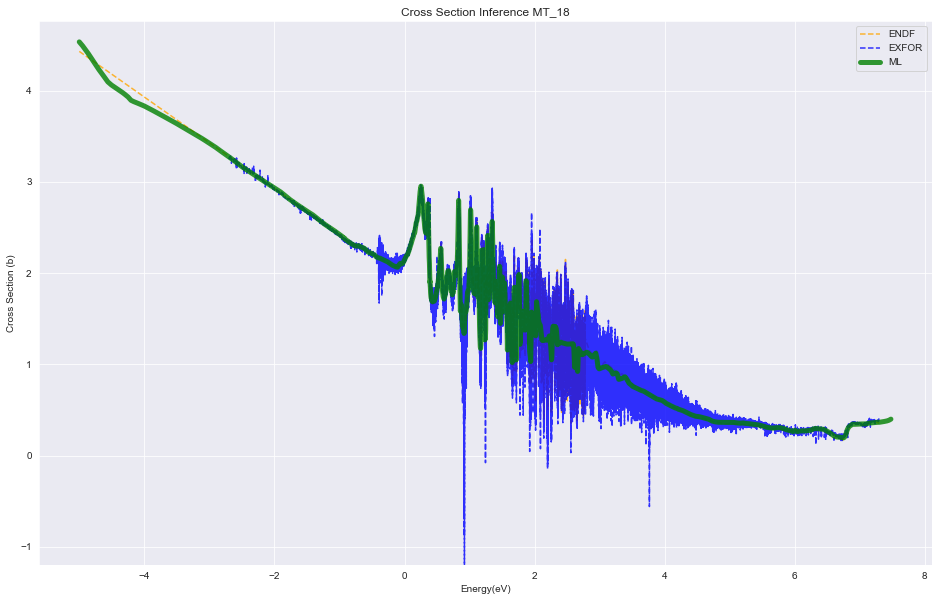

EXFOR VS ML: Original Data
The MSE is:  0.032715216718225026
The MAE is:  0.12299253853309611
ENDF vs EXFOR:
The MSE is:  0.020448481724628136
The MAE is:  0.09105713111655128


In [44]:
run_uranium(testing_model)

Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 59)


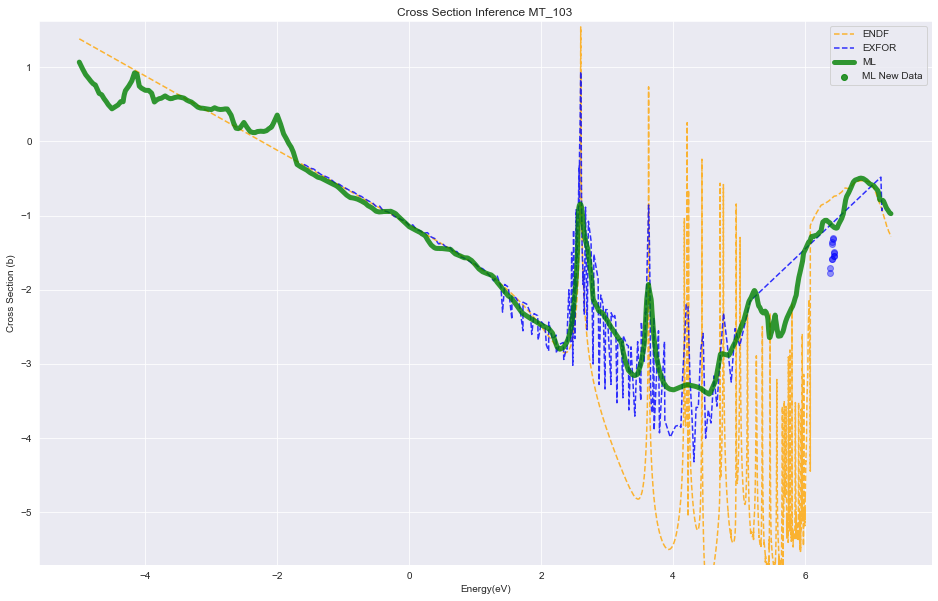

EXFOR VS ML: Original Data
The MSE is:  0.2249499158394837
The MAE is:  0.3123585040228868
EXFOR VS ML: New Data
The MSE is:  17933445028.6938
The MAE is:  133915.8132135976
ENDF vs EXFOR:
The MSE is:  1.1655660180001288
The MAE is:  0.7164696137547178
NEW DATA: ENDF vs EXFOR:
The MSE is:  0.5797513174524701
The MAE is:  0.7490906564440888


In [161]:
run_chlorine(histories["8_Layers_600_Units_E"].model)